# Final Version

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Masking, LSTM, BatchNormalization, Dropout, Attention, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Preprocess

In [38]:
!pip install pybaseball

import pandas as pd
from pybaseball import statcast_pitcher, playerid_lookup
import csv

In [39]:
input_last_name = "Hunter"
input_first_name = "Greene"
input_start_date = '2024-04-01'
input_end_date = '2024-11-02'
# Look up player ID
pitcher_id = playerid_lookup(input_first_name, input_last_name).key_mlbam[0]

# Output path for the CSV
output_root = 'input_all_data_2024.csv'

# Fetch all data for the pitcher in the given date range
data = statcast_pitcher(input_start_date, input_end_date, player_id=pitcher_id)

# Save the complete dataset to a CSV file
data.to_csv(output_root, index=False, encoding='utf-8')

print(f"All data successfully saved to {output_root}!")

Gathering Player Data
All data successfully saved to input_all_data_2024.csv!


### Transform data
NOTE: the value range and number of unique values below are just an estimation, it's merely listed to help you understand each feature.

Abbreviations: b.n. before normalization, b.e. before encoding.

Normalized features:
- release_speed (value 0~105)
- launch_speed (value 0~120, empty=>0 b.n.)
- launch_angle (value -90~90, empty=>0 b.n.)
- hit_distance_sc (value 0~400, empty=>0 b.n.)

One-hot encoded features:
- pitch_type (unique 7) (as an input feature, don't use one-hot for output)
- strikes (unique 3)
- balls (unique 4)
- zone (unique 14)
- description (unique 11)
- bb_type (unique 4, empty=>str b.e)

Embedded features:
- batter (integer ID)

TODO: try these
- score_difference, on_1b_bool, etc., outs_when_up, weighted_on_base, scoring_position_weighted

In [61]:
# Read data and reverse it (sorted by Game Date)
data = pd.read_csv('input_all_data_2024.csv')
# data = pd.read_csv('mason_miller_all_data_2024.csv')
# data = pd.read_csv('shohei_ohtani_all_data_2022_2023.csv')
data = data.iloc[::-1].reset_index(drop=True)

print(len(set(data['bb_type'])))
print(len(set(data['description'])))
print(len(set(data['bb_type'])))
print(len(set(data['pitch_type'])))

5
10
5
4


## (1) Create subsequence by batter id

We will store raw data in `data` and processed data in `processed_data` with only the target features.

In [62]:
processed_data = pd.DataFrame()
processed_output = pd.DataFrame()

### CONFIGURE ###
normalized_features = ['release_speed', 'launch_speed', 'launch_angle', 'hit_distance_sc']
normalized_features_possibly_missing = ['launch_speed', 'launch_angle', 'hit_distance_sc']

one_hot_features = ['pitch_type', 'strikes', 'balls', 'zone', 'description', 'bb_type']
one_hot_features_possibly_missing = ['bb_type']

embedded_features = ['batter']

output_feature = 'pitch_type'
### CONFIGURE ###

# Normalization
for feature in normalized_features:
    processed_data[feature] = data[feature]
    # Fill empty entries with 0
    if feature in normalized_features_possibly_missing:
        processed_data[feature] = processed_data[feature].fillna(0)
    # Normalize
    scaler = MinMaxScaler(feature_range=(-1, 1))
    processed_data[feature] = scaler.fit_transform(processed_data[[feature]])

# One-Hot Encode
ont_hot_tmp_df = pd.DataFrame()
for feature in one_hot_features:
    ont_hot_tmp_df[feature] = data[feature]
    # Fill empty entries with 'Unknown'
    if feature in one_hot_features_possibly_missing:
        ont_hot_tmp_df[feature] = ont_hot_tmp_df[feature].fillna('Unknown')
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded = one_hot_encoder.fit_transform(ont_hot_tmp_df[one_hot_features])
processed_data[one_hot_encoder.get_feature_names_out(one_hot_features)] = encoded

# Label encode for embedding
for feature in embedded_features:
    processed_data[feature] = data[feature]
    label_encoder = LabelEncoder()
    processed_data[feature] = label_encoder.fit_transform(processed_data[feature])

# Label output
label_encoder = LabelEncoder()
processed_output[output_feature] = label_encoder.fit_transform(data[output_feature])

# Final processed dataset
print("Processed Data Shape:", processed_data.shape)
processed_data, processed_output

Processed Data Shape: (2463, 44)


(      release_speed  launch_speed  launch_angle  hit_distance_sc  \
 0          0.725322     -1.000000     -0.023256        -1.000000   
 1         -0.090129     -1.000000     -0.023256        -1.000000   
 2         -0.321888     -1.000000     -0.023256        -1.000000   
 3          0.828326     -1.000000     -0.023256        -1.000000   
 4         -0.098712     -0.097970     -0.174419        -0.959276   
 ...             ...           ...           ...              ...   
 2458       0.725322      0.503972      0.220930         0.194570   
 2459       0.776824      0.774051      0.360465         0.533937   
 2460       0.613734     -1.000000     -0.023256        -1.000000   
 2461      -0.236052     -1.000000     -0.023256        -1.000000   
 2462       0.699571     -1.000000     -0.023256        -1.000000   
 
       pitch_type_CU  pitch_type_FF  pitch_type_FS  pitch_type_SL  strikes_0  \
 0               0.0            1.0            0.0            0.0        1.0   
 1        

### Create Subsequences

In [63]:
# Assuming y_label_encoder is your LabelEncoder instance
pitch_type_mapping = {index: pitch_type for index, pitch_type in enumerate(label_encoder.classes_)}
print("Pitch Type Encoding:")
for index, pitch_type in pitch_type_mapping.items():
    print(f"{pitch_type}: {index}")

Pitch Type Encoding:
CU: 0
FF: 1
FS: 2
SL: 3


In [64]:
# prompt: find number of each classes

import pandas as pd

# Load the data (assuming the code you provided has already created 'processed_output')
# Replace 'processed_output.csv' with the actual filename if it's saved as a CSV
# processed_output = pd.read_csv('processed_output.csv')

# Access the 'pitch_type' column (assuming it exists) and get value counts
pitch_type_counts = processed_output['pitch_type'].value_counts()

# Print the counts for each class
pitch_type_counts

,count
pitch_type,
1,1373
3,838
2,208
0,44


In [65]:
# Step 3: Initialize variables for creating sequences
# numeric_features = ['isStrike', 'Zone', 'Strike Detail']
# categorical_features = ['Pitch type']
batter_column = 'batter'

# List to store sequences
sequences = []
current_sequence = []
current_batter_id = None

# Step 4: Iterate through the dataset row by row
for index, row in processed_data.iterrows():
    batter_id = row[batter_column]
    row_features = row.values

    if batter_id != current_batter_id and current_sequence:
        # If batter changes or we're at the end of a sequence, save the current sequence
        sequences.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })

# Convert sequences into a structured format if needed
sequence_array = [entry['Sequence'] for entry in sequences]

In [66]:
def pad_sequence(sequence, target_length=12, padding_value=0):
    """
    對序列進行填充，使其長度達到 target_length。

    :param sequence: 需要填充的序列
    :param target_length: 目標長度
    :param padding_value: 填充的數值，預設為 0
    :return: 填充後的序列
    """
    current_length = len(sequence)

    # 如果當前序列長度小於目標長度，則進行填充
    if current_length < target_length:
        padding_needed = target_length - current_length
        # 使用 np.pad 來填充序列，填充行的數量
        padded_sequence = np.pad(sequence,
                                 ((0, padding_needed), (0, 0)),  # 填充的行和列
                                 mode='constant', constant_values=padding_value)
        return padded_sequence
    else:
        return sequence  # 如果序列長度已經足夠長，則返回原始序列

In [67]:
all_sequences = []
for batter in sequences:
    batter_id = batter['Batter ID']  # 獲取打者 ID
    # print(batter_id)

    batter_sequences = batter['Sequence']  # 獲取該打者的所有序列
    sequence_length=len(batter_sequences)
    for length in range(1, sequence_length):  # 子序列的長度從 1 到 sequence_length
      for start_idx in range(sequence_length - length ):  # 每個起始位置
        sub_sequence = batter_sequences[start_idx:start_idx + length]  # 取得子序列
        padded_sub_sequence = pad_sequence(sub_sequence, target_length=12)
        all_sequences.append(padded_sub_sequence)


X=np.array(all_sequences)
X.shape

(5002, 12, 44)

In [68]:
batter_column = 'batter'

# List to store sequences
sequences = []
current_sequence = []
current_batter_id = None

# Step 4: Iterate through the dataset row by row
for index, row in processed_data.iterrows():
    batter_id = row[batter_column]
    row_features = processed_output.iloc[index].values

    if batter_id != current_batter_id and current_sequence:
        # If batter changes or we're at the end of a sequence, save the current sequence
        sequences.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })

# Convert sequences into a structured format if needed
sequence_array = [entry['Sequence'] for entry in sequences]
y_sequences = []
for batter in sequences:
    batter_id = batter['Batter ID']  # 獲取打者 ID

    batter_sequences = batter['Sequence']  # 獲取該打者的所有序列
    sequence_length=len(batter_sequences)
    for length in range(1, sequence_length):  # 子序列的長度從 1 到 sequence_length
      for start_idx in range(1,sequence_length - length+1):  # 每個起始位置
    #   for start_idx in range(sequence_length - length,sequence_length - length+1):  # 每個起始位置
        sub_sequence = batter_sequences[start_idx + length - 1]  # 取得子序列
        # padded_sub_sequence = pad_sequence(sub_sequence, target_length=12)
        y_sequences.append(sub_sequence)

y=np.array(y_sequences)
y[10:13], processed_output.iloc[3:8]

(array([[2],
        [3],
        [3]]),
    pitch_type
 3           1
 4           3
 5           1
 6           2
 7           3)

specialist dataset


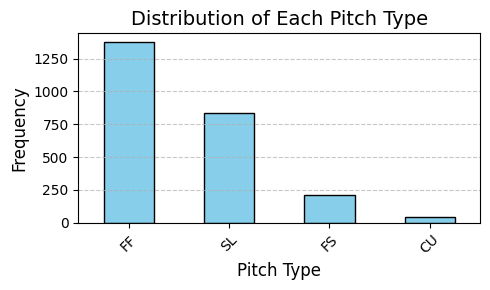

In [69]:
pitch_type_distribution = data['pitch_type'].value_counts()
plt.figure(figsize=(5, 3))
pitch_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Each Pitch Type", fontsize=14)
plt.xlabel("Pitch Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [70]:
# 找出 y 中值不等于 4、5、7 的索引
indice_special_y = np.where((y.flatten() != 1) & (y.flatten() != 3) )[0]


# 使用这些索引从 X 中提取对应的行
X_special = X[indice_special_y]
y_special = y[indice_special_y]





In [71]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# First, split into training and temp (validation + testing)
X_special_train, X_special_temp, y_special_train, y_special_temp = train_test_split(X_special, y_special, test_size=(1 - train_ratio), random_state=42)

# Then, split temp into validation and testing
val_test_ratio = test_ratio / (test_ratio + val_ratio)  # Adjust split ratio for remaining data
X_special_val, X_special_test, y_special_val, y_special_test = train_test_split(X_special_temp, y_special_temp, test_size=val_test_ratio, random_state=42)

# Print dataset sizes
print(f"Training set: {X_special_train.shape}, {y_special_train.shape}")
print(f"Validation set: {X_special_val.shape}, {y_special_val.shape}")
print(f"Testing set: {X_special_test.shape}, {y_special_test.shape}")

Training set: (257, 12, 44), (257, 1)
Validation set: (86, 12, 44), (86, 1)
Testing set: (86, 12, 44), (86, 1)


## (2) Create subsequence by game date

In [ ]:
processed_data = pd.DataFrame()
processed_output = pd.DataFrame()

### CONFIGURE ###
normalized_features = ['release_speed', 'launch_speed', 'launch_angle', 'hit_distance_sc']
normalized_features_possibly_missing = ['launch_speed', 'launch_angle', 'hit_distance_sc']

one_hot_features = ['pitch_type', 'strikes', 'balls', 'zone', 'description', 'bb_type']
one_hot_features_possibly_missing = ['bb_type']

embedded_features = ['game_date']

output_feature = 'pitch_type'
### CONFIGURE ###

# Normalization
for feature in normalized_features:
    processed_data[feature] = data[feature]
    # Fill empty entries with 0
    if feature in normalized_features_possibly_missing:
        processed_data[feature] = processed_data[feature].fillna(0)
    # Normalize
    scaler = MinMaxScaler(feature_range=(-1, 1))
    processed_data[feature] = scaler.fit_transform(processed_data[[feature]])

# One-Hot Encode
ont_hot_tmp_df = pd.DataFrame()
for feature in one_hot_features:
    ont_hot_tmp_df[feature] = data[feature]
    # Fill empty entries with 'Unknown'
    if feature in one_hot_features_possibly_missing:
        ont_hot_tmp_df[feature] = ont_hot_tmp_df[feature].fillna('Unknown')
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded = one_hot_encoder.fit_transform(ont_hot_tmp_df[one_hot_features])
processed_data[one_hot_encoder.get_feature_names_out(one_hot_features)] = encoded

# Label encode for embedding
for feature in embedded_features:
    processed_data[feature] = data[feature]
    label_encoder = LabelEncoder()
    processed_data[feature] = label_encoder.fit_transform(processed_data[feature])

# Label output
label_encoder = LabelEncoder()
processed_output[output_feature] = label_encoder.fit_transform(data[output_feature])

# Final processed dataset
print("Processed Data Shape:", processed_data.shape)
processed_data, processed_output


Processed Data Shape: (2590, 49)


(      release_speed  launch_speed  launch_angle  hit_distance_sc  \
 0          0.891892     -1.000000     -0.086420        -1.000000   
 1          0.945946     -1.000000     -0.086420        -1.000000   
 2          0.906634      0.715035      0.209877         0.596372   
 3          0.936118      0.386364      0.061728        -0.301587   
 4          0.484029     -1.000000     -0.086420        -1.000000   
 ...             ...           ...           ...              ...   
 2585       0.778870     -1.000000     -0.086420        -1.000000   
 2586       0.837838     -1.000000     -0.086420        -1.000000   
 2587       0.690418      0.253497     -0.740741        -0.995465   
 2588       0.818182     -1.000000     -0.086420        -1.000000   
 2589       0.429975      0.625874     -0.222222        -0.959184   
 
       pitch_type_CH  pitch_type_CS  pitch_type_CU  pitch_type_FC  \
 0               0.0            0.0            0.0            0.0   
 1               0.0            

In [ ]:
# Step 3: Initialize variables for creating sequences
# numeric_features = ['isStrike', 'Zone', 'Strike Detail']
# categorical_features = ['Pitch type']
batter_column = 'game_date'

# List to store sequences
sequences = []
current_sequence = []
current_batter_id = None

# Step 4: Iterate through the dataset row by row
for index, row in processed_data.iterrows():
    batter_id = row[batter_column]
    row_features = row.values

    if batter_id != current_batter_id and current_sequence:
        # If batter changes or we're at the end of a sequence, save the current sequence
        sequences.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })

# Convert sequences into a structured format if needed
sequence_array = [entry['Sequence'] for entry in sequences]


In [ ]:
def pad_sequence(sequence, target_length=30, padding_value=0):
    """
    對序列進行填充，使其長度達到 target_length。

    :param sequence: 需要填充的序列
    :param target_length: 目標長度
    :param padding_value: 填充的數值，預設為 0
    :return: 填充後的序列
    """
    current_length = len(sequence)

    # 如果當前序列長度小於目標長度，則進行填充
    if current_length < target_length:
        padding_needed = target_length - current_length
        # 使用 np.pad 來填充序列，填充行的數量
        padded_sequence = np.pad(sequence,
                                 ((0, padding_needed), (0, 0)),  # 填充的行和列
                                 mode='constant', constant_values=padding_value)
        return padded_sequence
    else:
        return sequence  # 如果序列長度已經足夠長，則返回原始序列

In [ ]:
all_sequences = []
for batter in sequences:
    batter_id = batter['Batter ID']  # 獲取打者 ID
    # print(batter_id)

    batter_sequences = batter['Sequence']  # 獲取該打者的所有序列
    sequence_length=30
    for length in range(20, sequence_length):  # 子序列的長度從 1 到 sequence_length
      for start_idx in range(sequence_length - length ):  # 每個起始位置
        sub_sequence = batter_sequences[start_idx:start_idx + length]  # 取得子序列
        padded_sub_sequence = pad_sequence(sub_sequence, target_length=30)
        all_sequences.append(padded_sub_sequence)


X=np.array(all_sequences)

print(X[1][0])
print(processed_data.iloc[[1]])
X.shape

[ 0.94594595 -1.         -0.08641975 -1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.        ]
   release_speed  launch_speed  launch_angle  hit_distance_sc  pitch_type_CH  \
1       0.945946          -1.0      -0.08642             -1.0            0.0   

   pitch_type_CS  pitch_type_CU  pitch_type_FC  pitch_type_FF  pitch_type_FS  \
1            0.0            0.0            0.0            1.0            0.0   

   ...  description_hit_into_play  description_missed_bunt  \
1  ...                        0.0                      0.0   

   description_swin

(1595, 30, 49)

In [ ]:
batter_column = 'game_date'

# List to store sequences
sequences = []
current_sequence = []
current_batter_id = None

# Step 4: Iterate through the dataset row by row
for index, row in processed_data.iterrows():
    batter_id = row[batter_column]
    row_features = processed_output.iloc[index].values

    if batter_id != current_batter_id and current_sequence:
        # If batter changes or we're at the end of a sequence, save the current sequence
        sequences.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })

# Convert sequences into a structured format if needed
sequence_array = [entry['Sequence'] for entry in sequences]
y_sequences = []
for batter in sequences:
    batter_id = batter['Batter ID']  # 獲取打者 ID

    batter_sequences = batter['Sequence']  # 獲取該打者的所有序列
    sequence_length=30
    for length in range(20, sequence_length):  # 子序列的長度從 1 到 sequence_length
      for start_idx in range(1,sequence_length - length+1):  # 每個起始位置
    #   for start_idx in range(sequence_length - length,sequence_length - length+1):  # 每個起始位置
        sub_sequence = batter_sequences[start_idx + length - 1]  # 取得子序列
        # padded_sub_sequence = pad_sequence(sub_sequence, target_length=12)
        y_sequences.append(sub_sequence)

y=np.array(y_sequences)
# y[10:13], processed_output.iloc[3:8]
y.shape

(1595, 1)

## Split data

In [98]:
# Define split ratios
train_ratio = 0.8
val_ratio = 0.05
test_ratio = 0.15

# First, split into training and temp (validation + testing)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)

# Then, split temp into validation and testing
val_test_ratio = test_ratio / (test_ratio + val_ratio)  # Adjust split ratio for remaining data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_test_ratio, random_state=42)

# Print dataset sizes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (4001, 12, 44), (4001, 1)
Validation set: (250, 12, 44), (250, 1)
Testing set: (751, 12, 44), (751, 1)


combine special+normal

In [91]:
# prompt: combine X_train and X _specail_train
indices_train = np.random.choice(X.shape[0], 100, replace=False)
indices_val= np.random.choice(X_val.shape[0], 20, replace=False)
indices_test = np.random.choice(X_test.shape[0], 100, replace=False)

# 根据索引提取样本
X_train_c= X[indices_train]
y_train_c = y[indices_train]

X_val_c = X_val[indices_val]
y_val_c = y_val[indices_val]

X_test_c = X_test[indices_test]
y_test_c = y_test[indices_test]


# Combine X_train and X_special_train
X_combined_train = np.concatenate((X_train_c, X_special_train), axis=0)
y_combined_train = np.concatenate((y_train_c, y_special_train), axis=0)
X_combined_val = np.concatenate((X_val_c, X_special_val), axis=0)
y_combined_val = np.concatenate((y_val_c, y_special_val), axis=0)
X_combined_test = np.concatenate((X_test_c, X_special_test), axis=0)
y_combined_test = np.concatenate((y_test_c, y_special_test), axis=0)





In [95]:
# prompt: 幫我把y裡 label 是 0取11個 1取259個 2取49個 3取151個 餅取出他們對應的X

# Assuming 'y' and 'X' are defined as in your provided code.

# Number of samples to extract for each label
num_samples = {
    0: 11,
    1: 259,
    2: 49,
    3: 151,
}

X_extracted = []
y_extracted = []

for label, count in num_samples.items():
    # Find indices where y equals the current label
    label_indices = np.where(y == label)[0]

    # Randomly select 'count' indices
    selected_indices = np.random.choice(label_indices, size=min(count, len(label_indices)), replace=False)

    # Extract corresponding X and y values
    X_extracted.extend(X[selected_indices])
    y_extracted.extend(y[selected_indices])

# Convert to NumPy arrays
X_extracted = np.array(X_extracted)
y_extracted = np.array(y_extracted)

print("Shape of X_extracted:", X_extracted.shape)
print("Shape of y_extracted:", y_extracted.shape)

Shape of X_extracted: (470, 12, 44)
Shape of y_extracted: (470, 1)


## Model

## Simple RNN

In [99]:
# VERSION: simple RNN
# Number of unique pitch types (replace with actual number from your data)
num_classes = processed_output[output_feature].nunique()  # Assuming `y` is label-encoded
print(num_classes)

# Build the model
print(X_combined_train.shape)
model_special = Sequential([
    # Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input: (sequence_length, num_features)
    Masking(mask_value=0.0, input_shape=(X_combined_train.shape[1], X_combined_train.shape[2])),

    SimpleRNN(64, return_sequences=False),  # RNN with 64 units
    Dense(32, activation='relu'),           # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model_special.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for label-encoded targets
    metrics=['accuracy']
)
model = Sequential([
    # Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input: (sequence_length, num_features)
    Masking(mask_value=0.0, input_shape=(X_combined_train.shape[1], X_combined_train.shape[2])),

    SimpleRNN(64, return_sequences=False),  # RNN with 64 units
    Dense(32, activation='relu'),           # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for label-encoded targets
    metrics=['accuracy']
)

model_special.summary()

4
(357, 12, 44)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_8 (Masking)                  │ (None, 12, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 64)                  │           6,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,188 (35.89 KB)

 Trainable params: 9,188 (35.89 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
history = model_special.fit(
    X_combined_train, y_combined_train,          # Training data
    validation_data=(X_combined_val, y_combined_val),  # Validation data
    epochs=60,                 # Number of epochs
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1                  # Verbosity level
)

Epoch 1/60
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6522 - loss: 0.9817

TypeError: Failed to convert elements of (None, 1) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.

In [101]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(
    X_train, y_train,          # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=60,                 # Number of epochs
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1                  # Verbosity level
)

Epoch 1/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4869 - loss: 1.1571 - val_accuracy: 0.4920 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 2/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5857 - loss: 0.9126 - val_accuracy: 0.4920 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 3/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5911 - loss: 0.8953 - val_accuracy: 0.5040 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 4/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5981 - loss: 0.8852 - val_accuracy: 0.5040 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 5/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6115 - loss: 0.8798 - val_accuracy: 0.5120 - val_loss: 1.0309 - learning_rate: 0.0010
Epoch 6/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6125 - loss: 0.8551 - val_accuracy: 0.5120 - val_loss: 0.9806 - learning_rate: 0.0010
Epoch 7/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6064 - loss: 0.8720 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


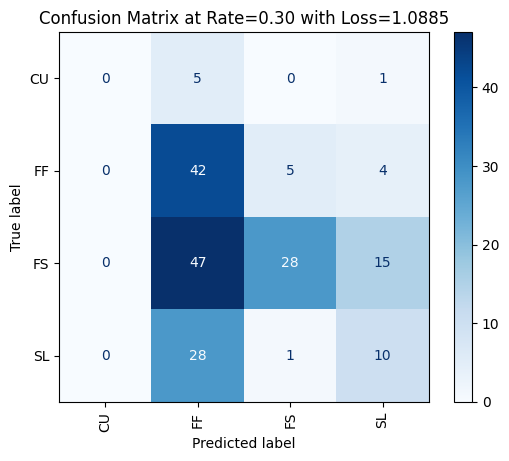

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


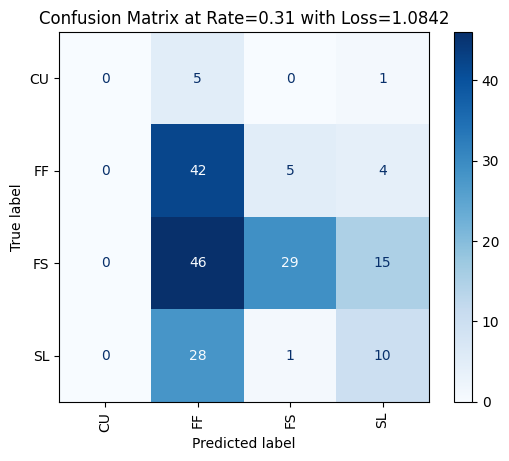

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


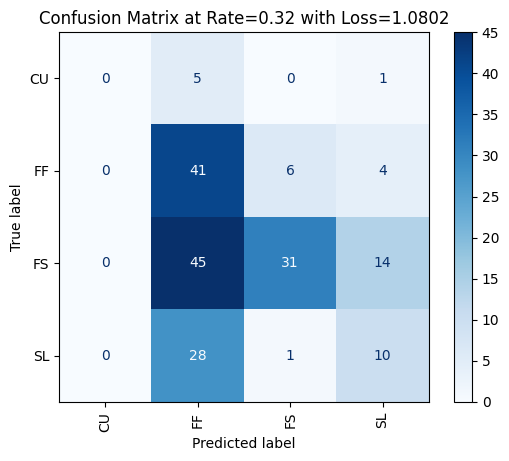

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


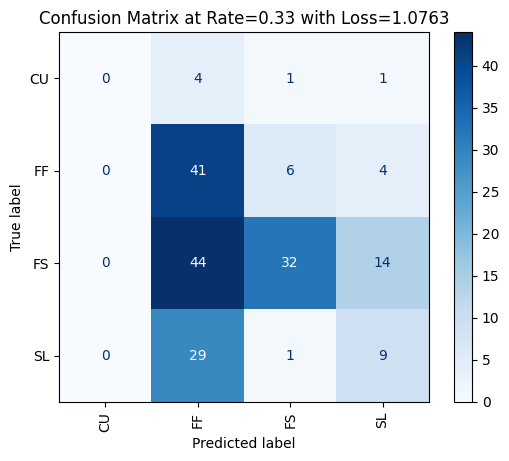

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


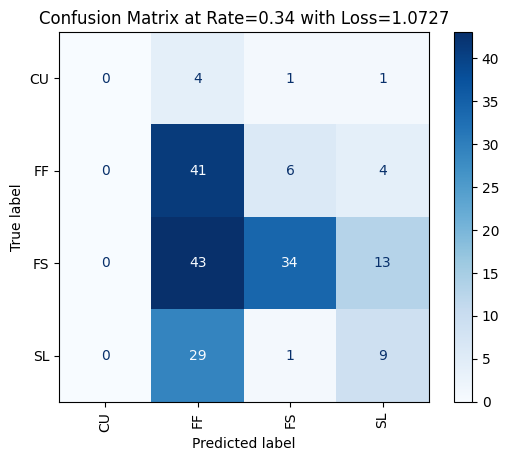

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


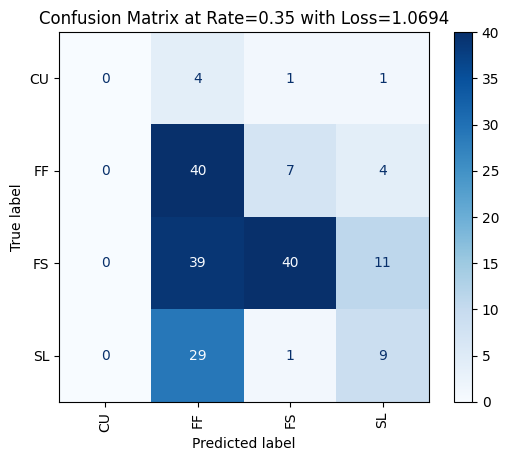

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


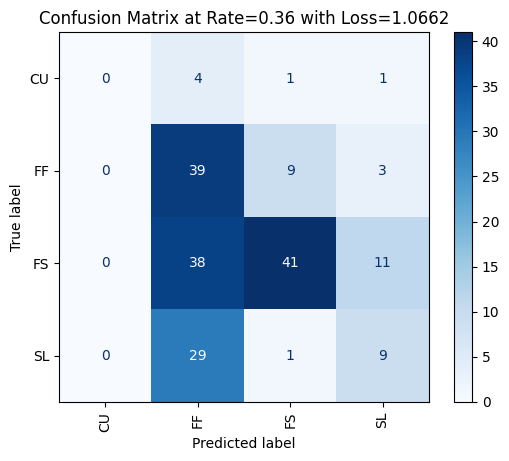

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


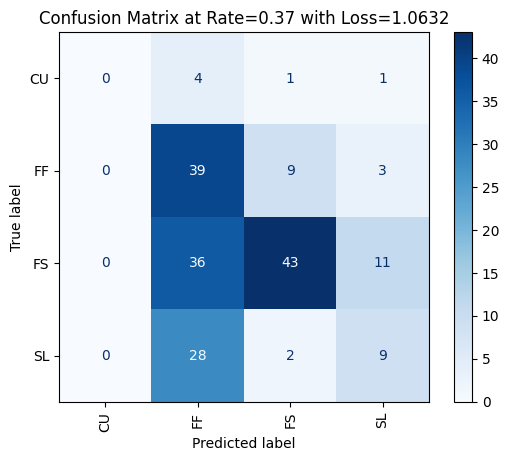

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


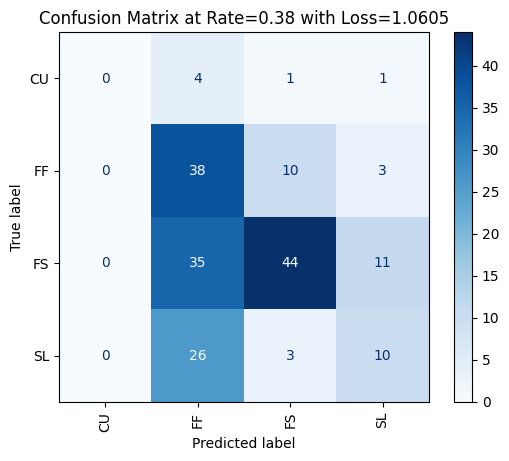

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


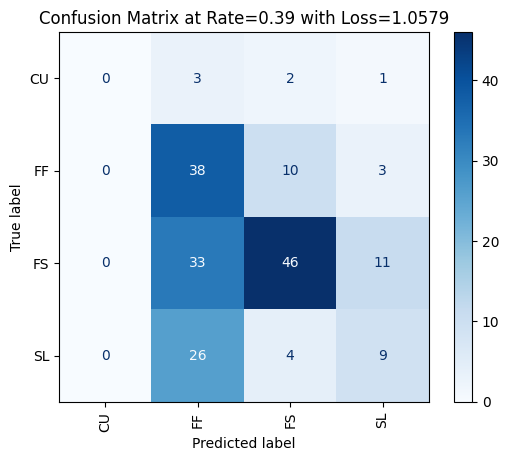

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


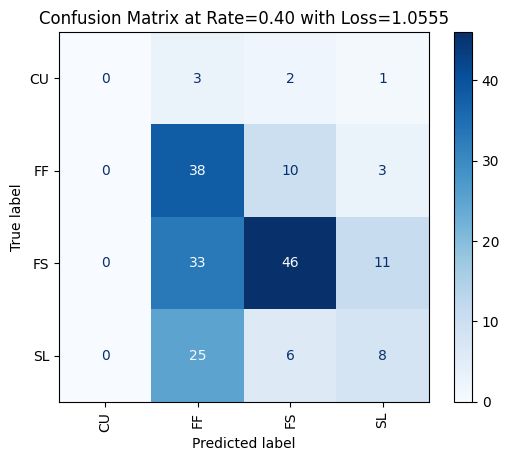

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


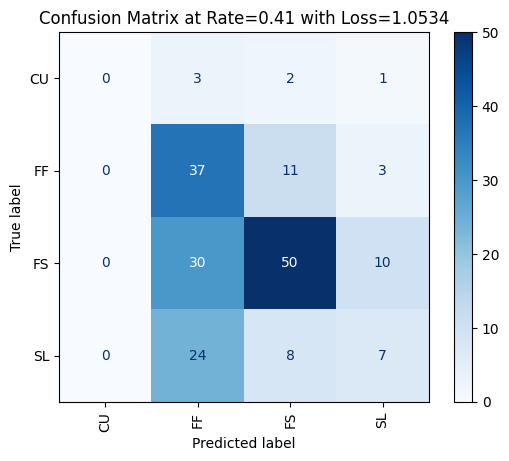

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


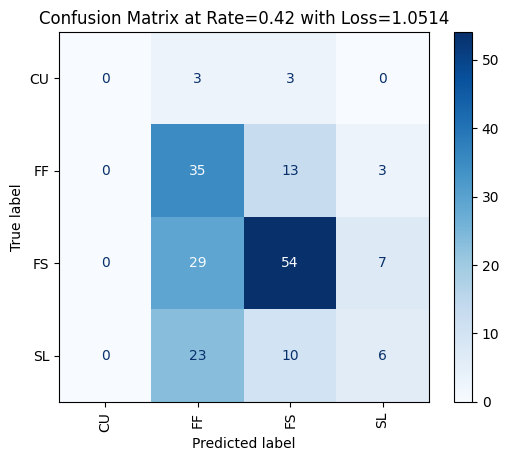

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


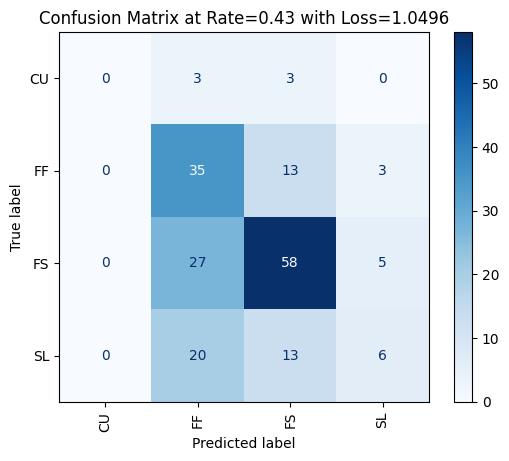

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


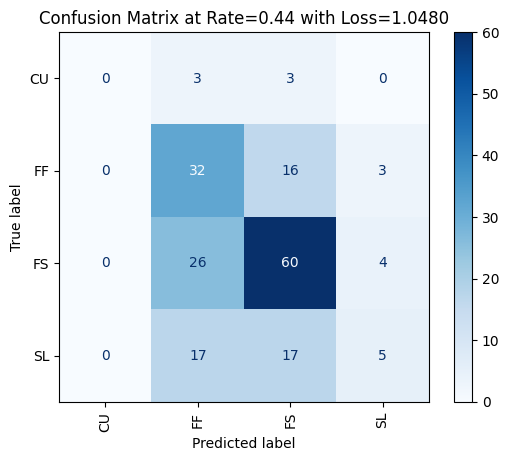

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


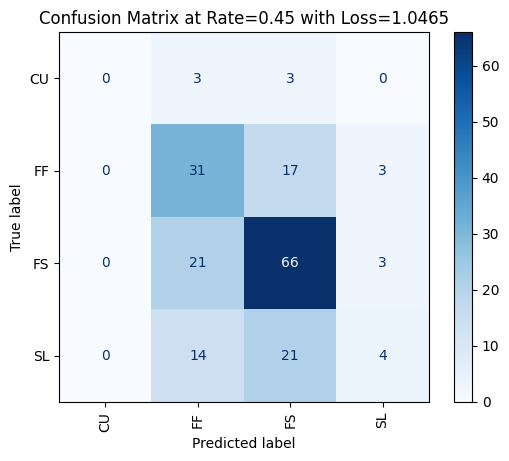

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


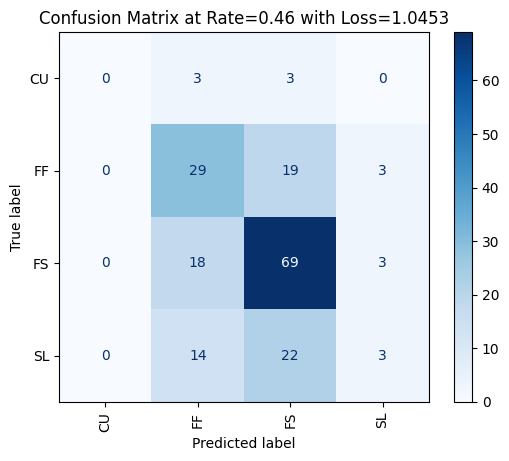

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


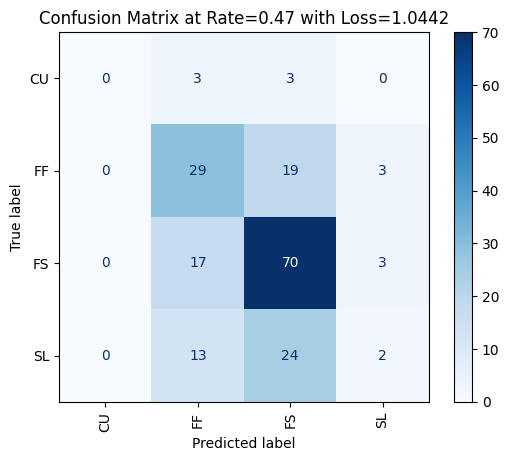

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


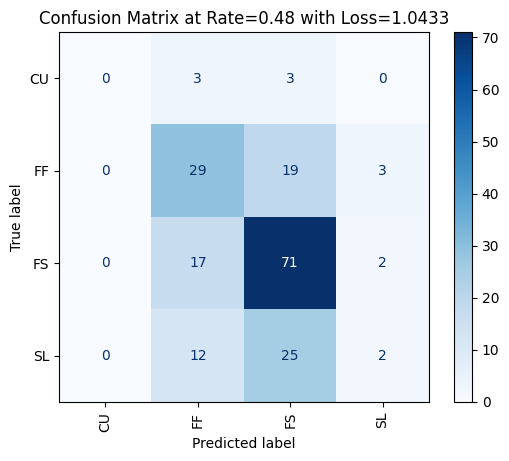

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


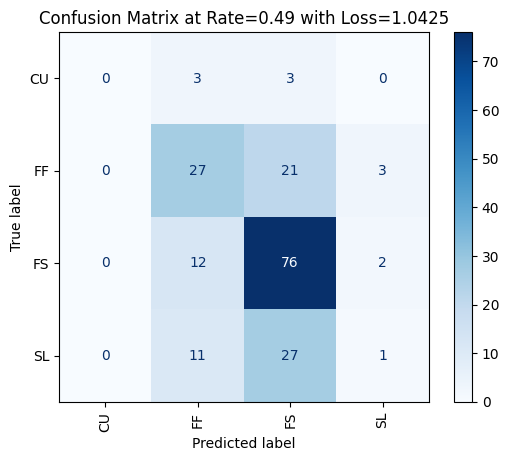

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


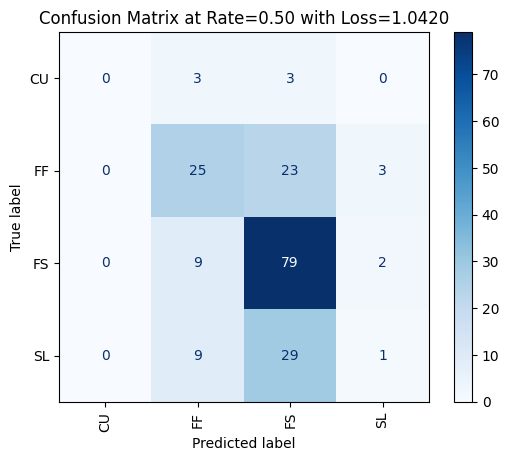

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


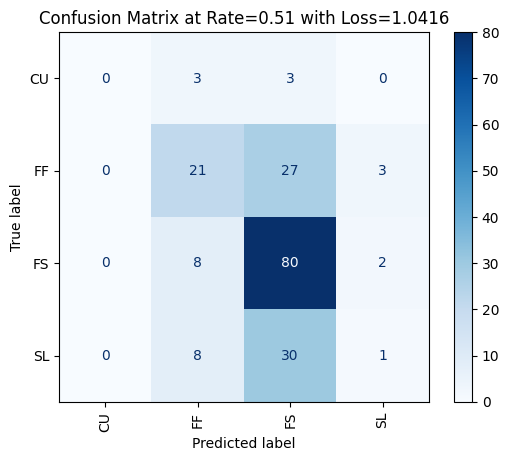

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


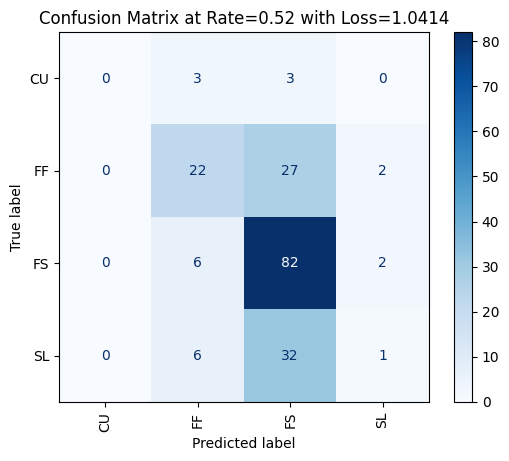

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


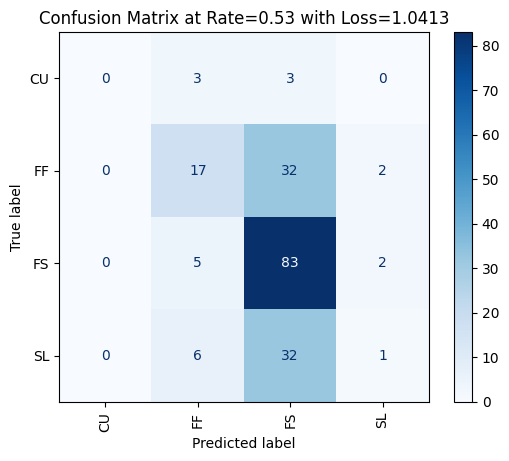

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


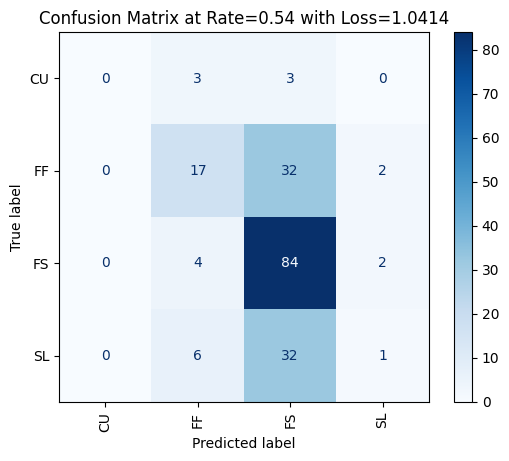

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


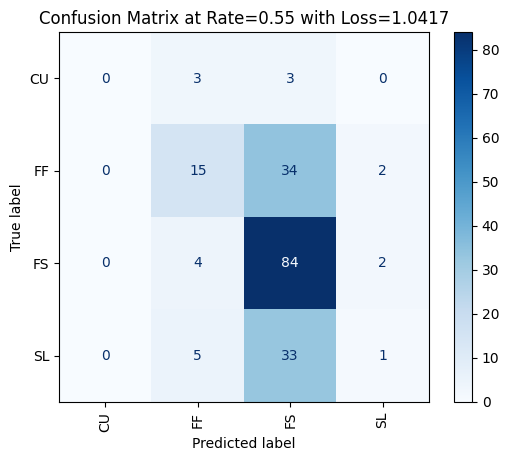

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


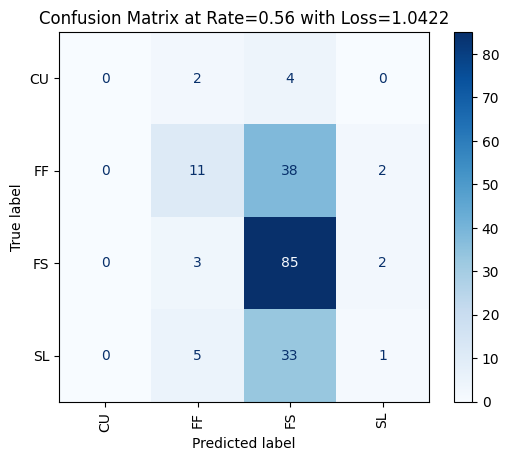

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


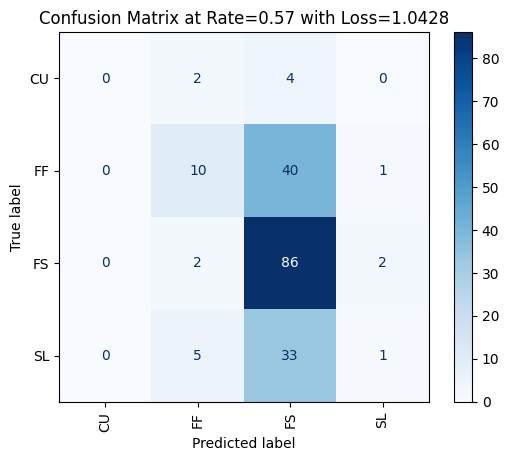

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


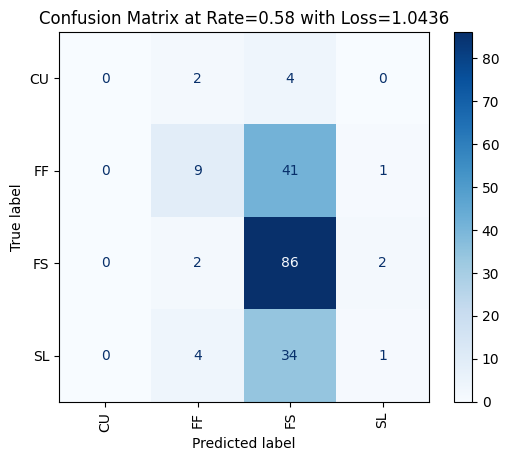

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


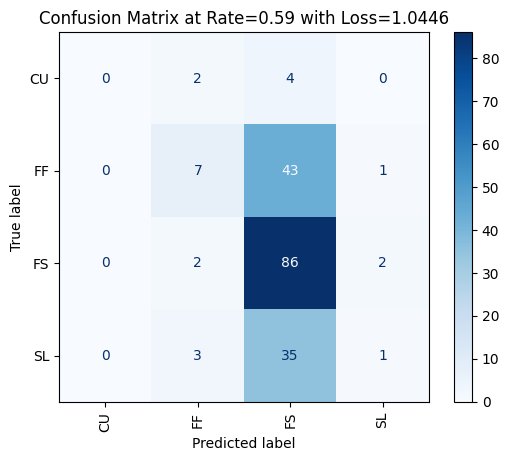

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


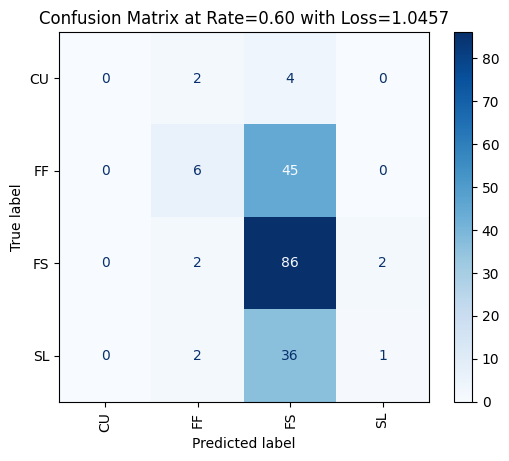

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


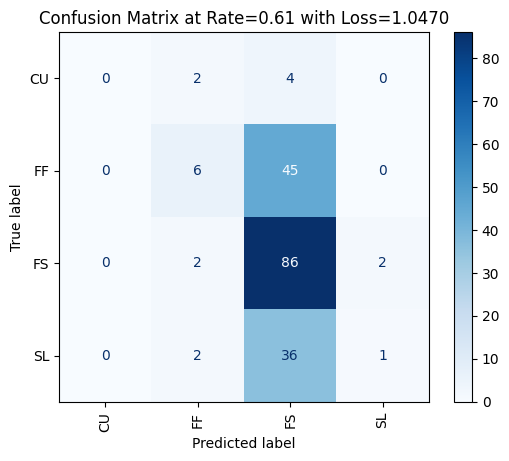

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


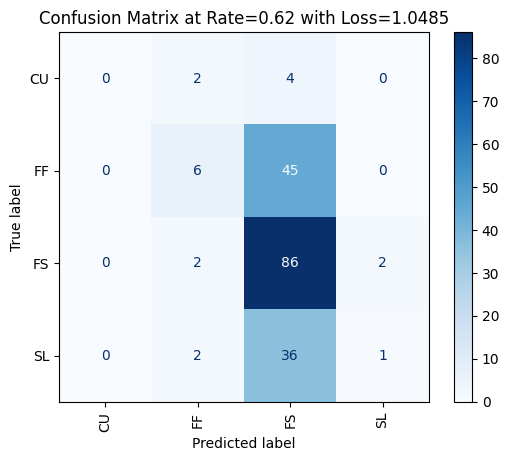

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


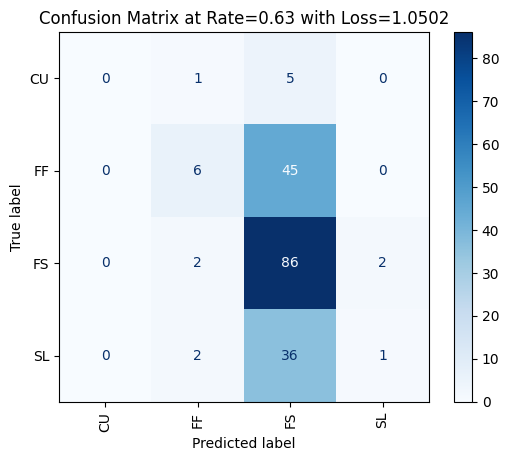

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


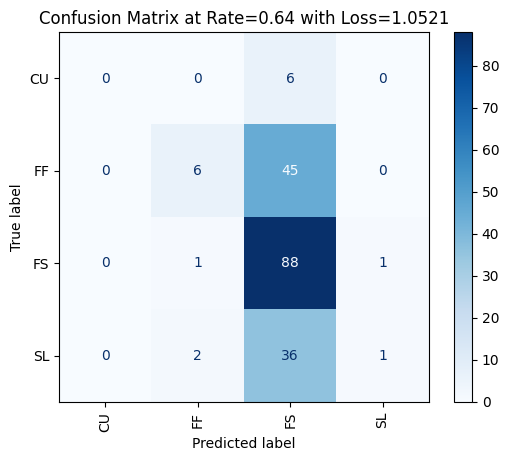

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


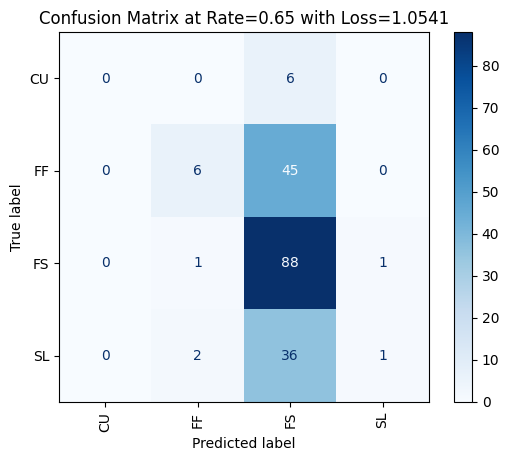

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


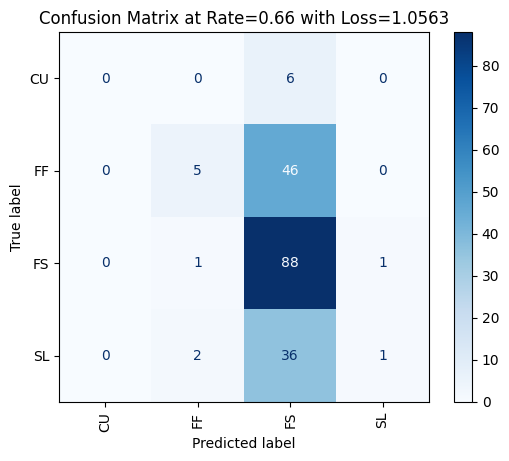

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


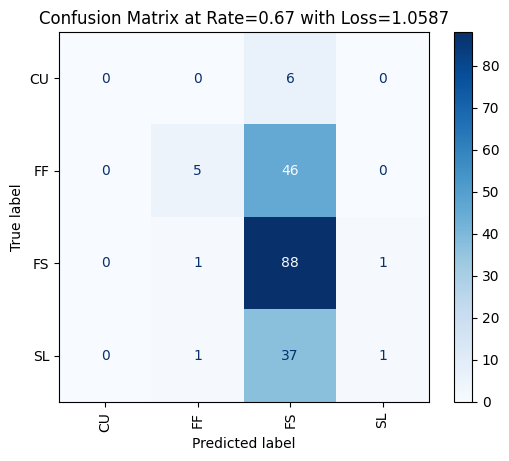

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


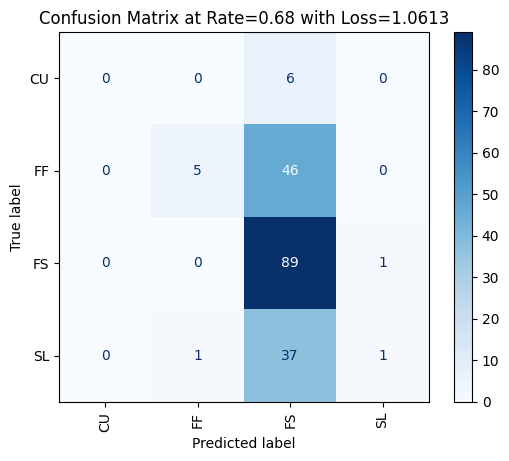

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


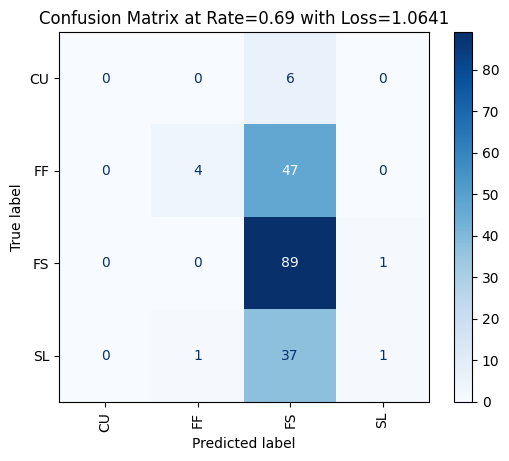

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


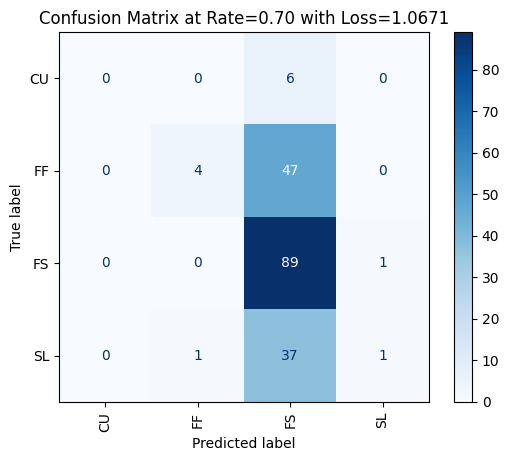

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


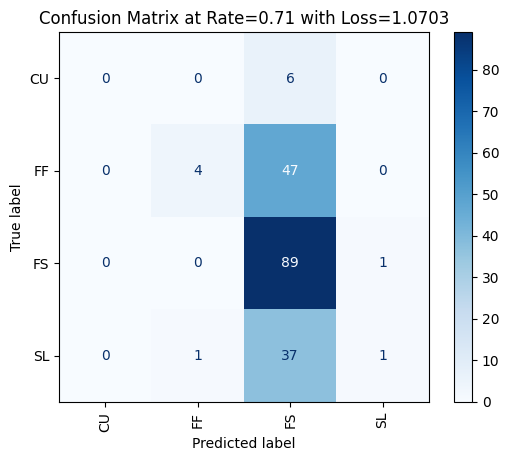

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


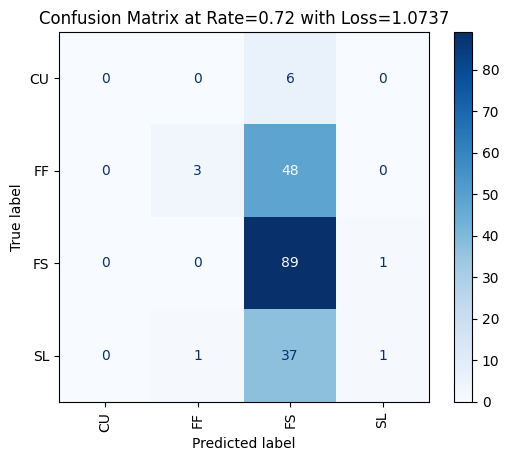

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


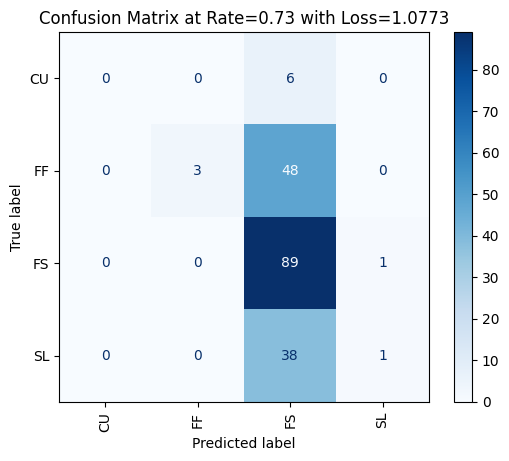

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


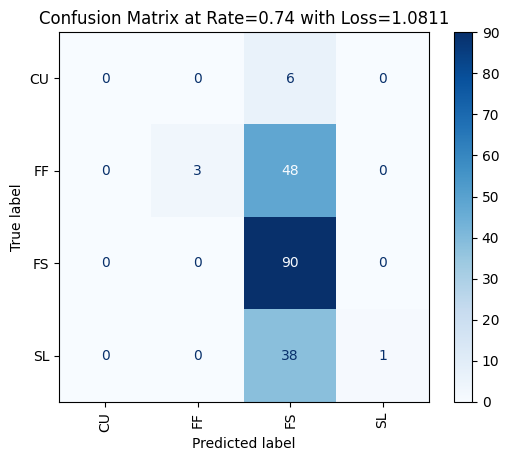

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


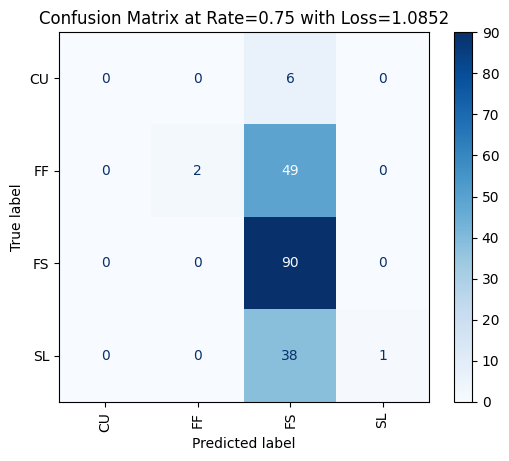

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


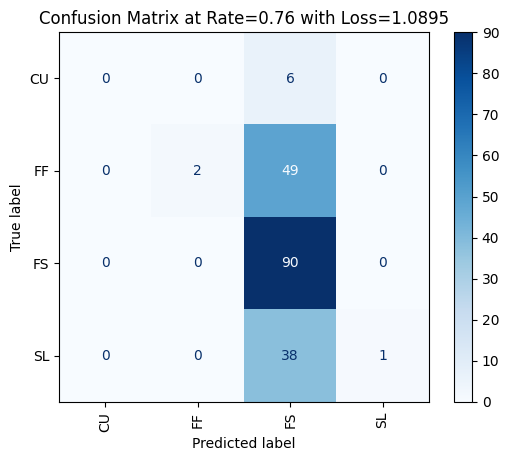

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


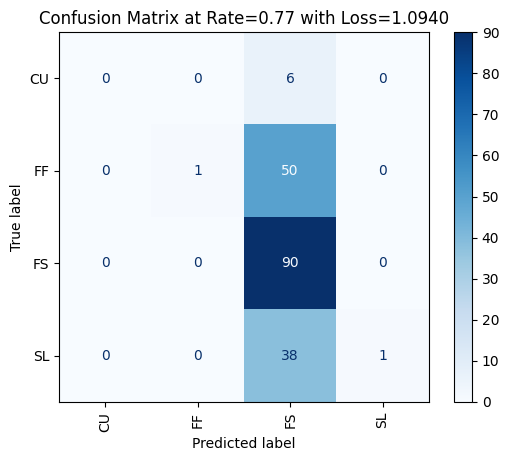

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


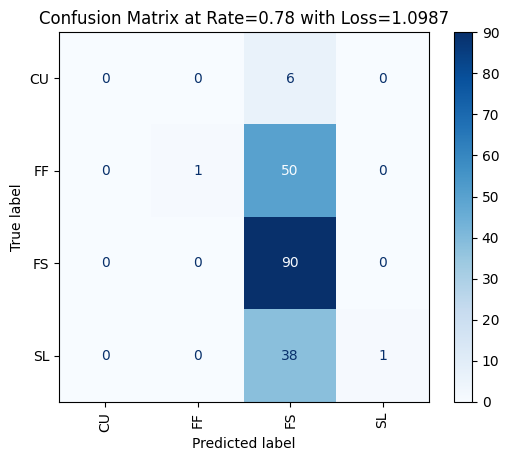

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


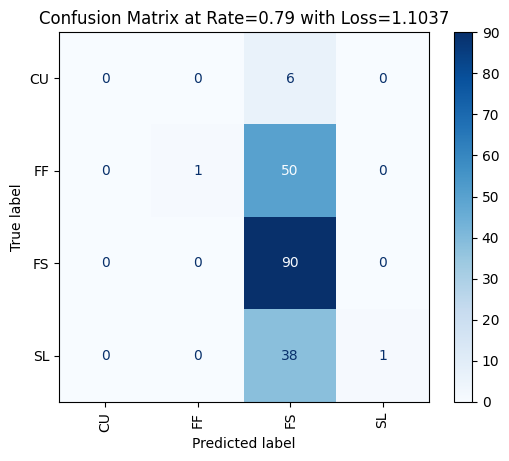

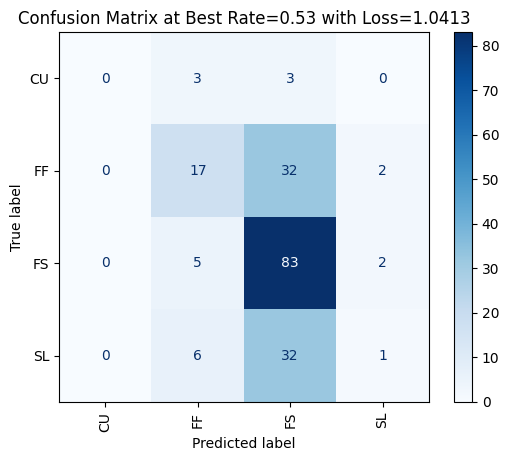

Best Rate: 0.53
Best Loss: 1.0413


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7196 - loss: 0.9259
Testing Loss: 0.903130054473877
Testing Accuracy: 0.6106383204460144
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


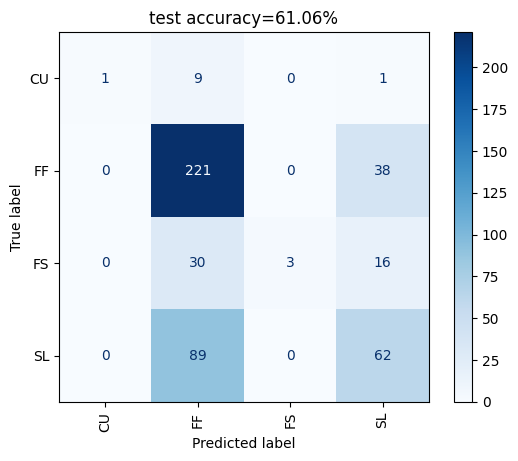

In [106]:
test_loss, test_accuracy = model.evaluate(X_extracted, y_extracted, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# 使用模型進行預測
y_pred = model.predict(X_extracted)
y_pred_classes = np.argmax(y_pred, axis=1)  # 預測的類別

# 計算混淆矩陣
cm = confusion_matrix(y_extracted, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'test accuracy={test_accuracy:.2%}')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


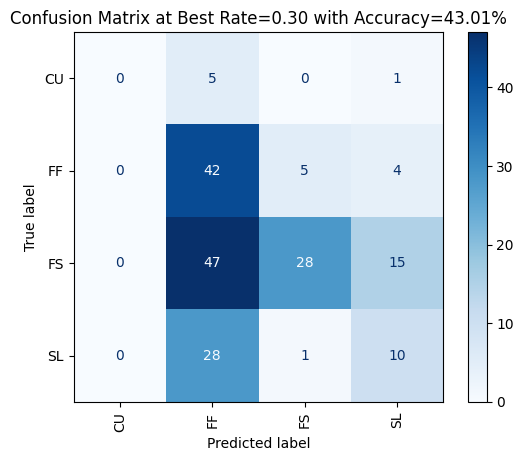

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


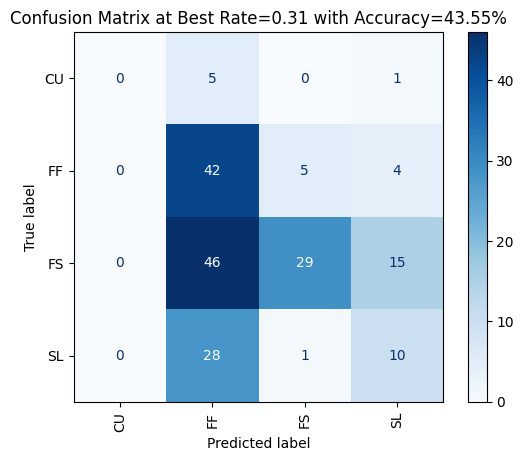

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


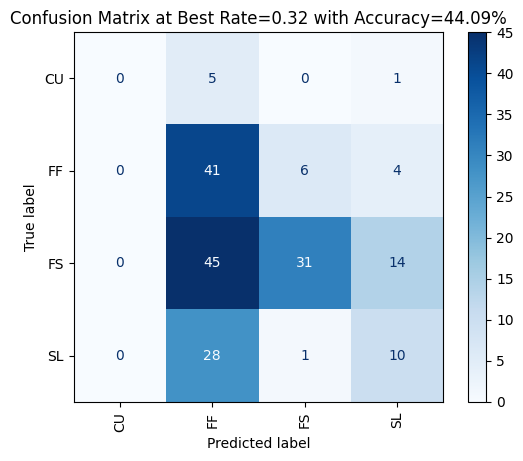

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


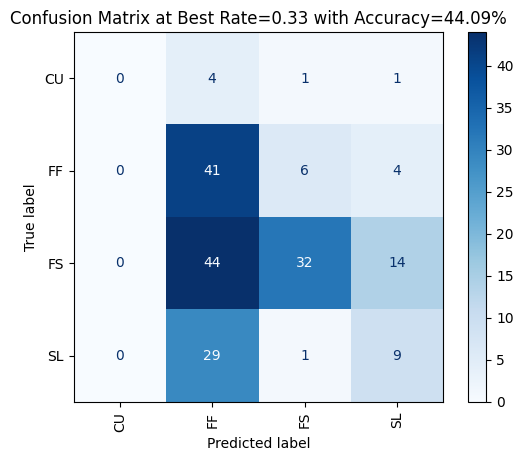

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


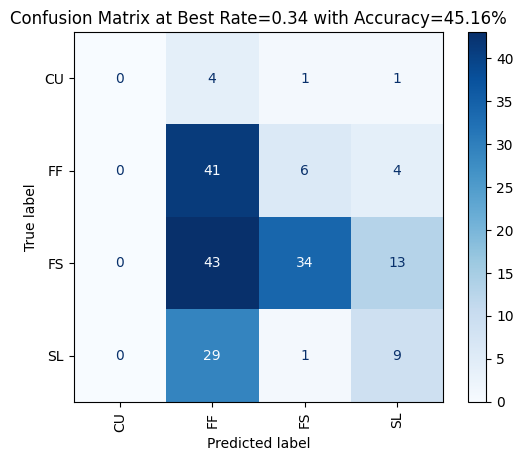

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


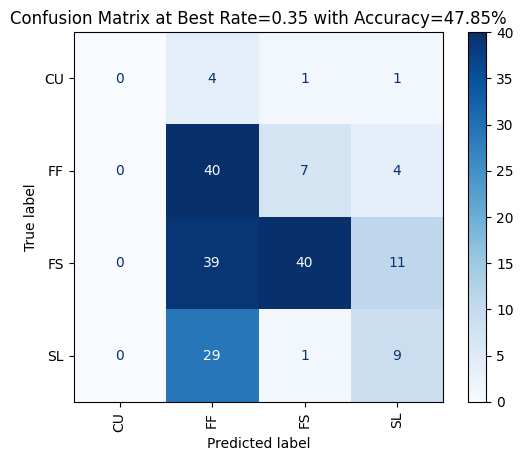

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


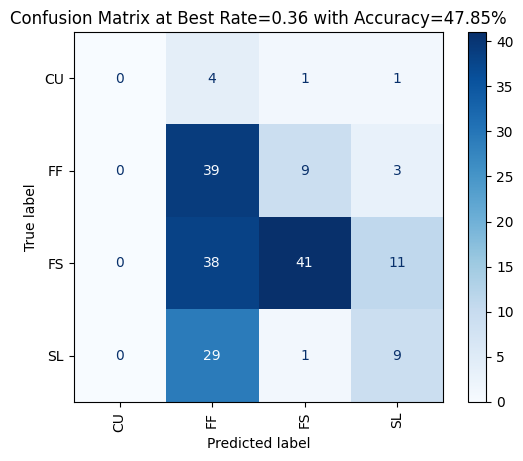

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


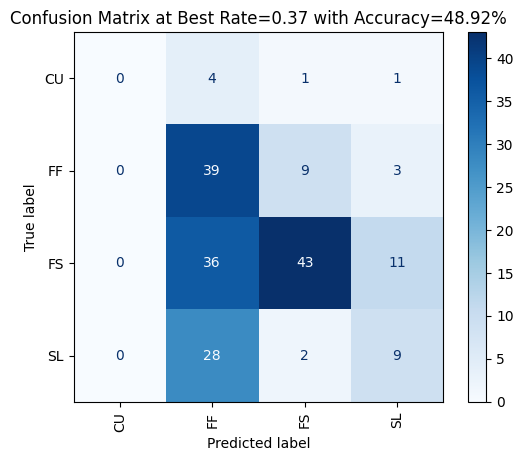

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


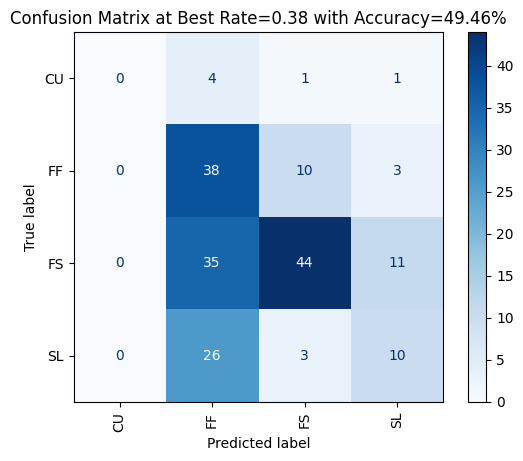

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


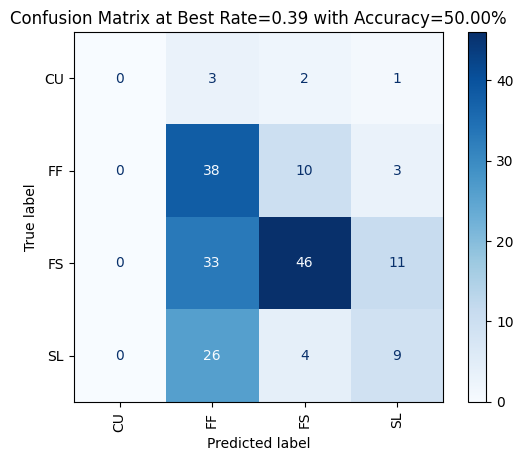

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


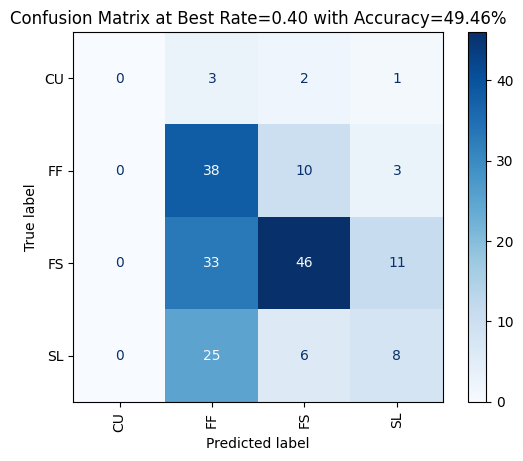

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


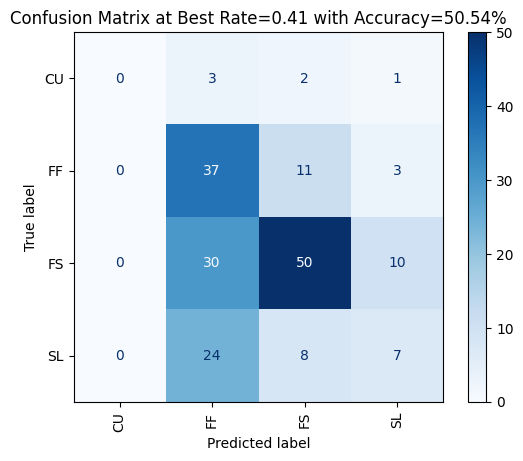

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


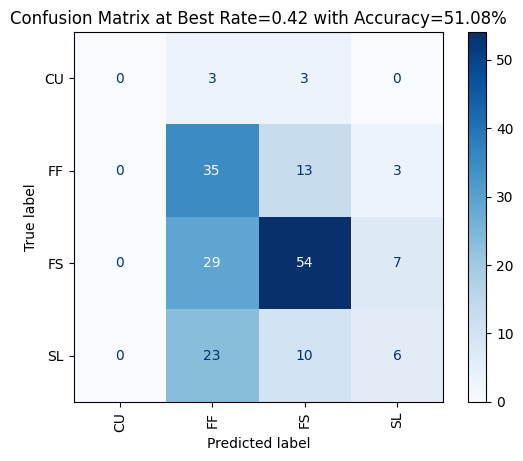

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


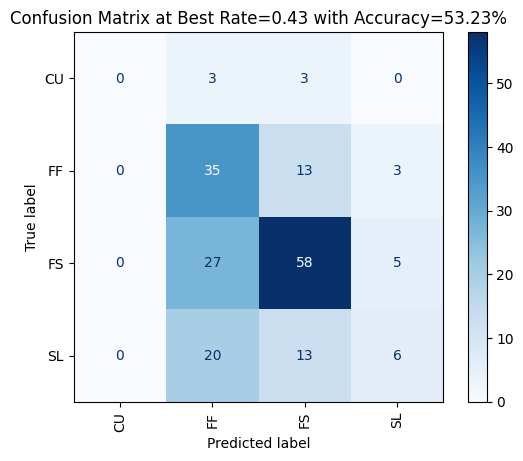

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


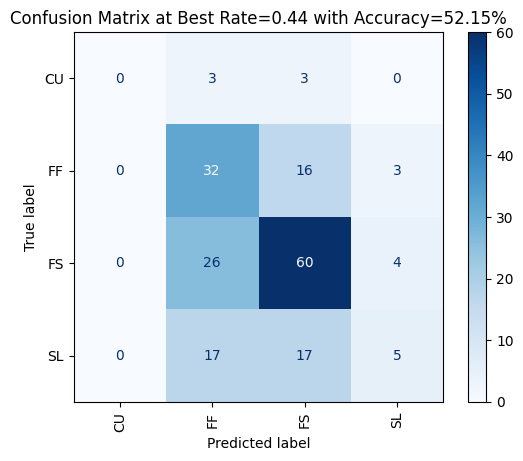

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


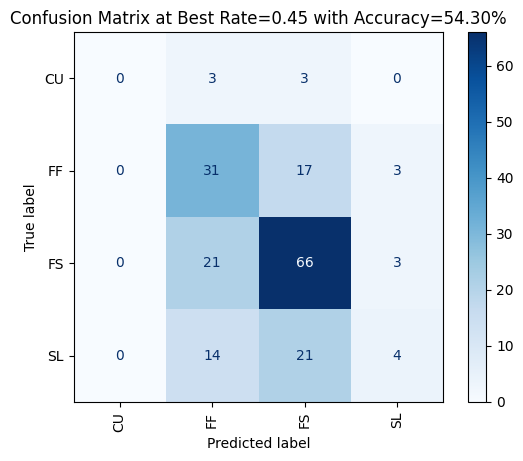

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


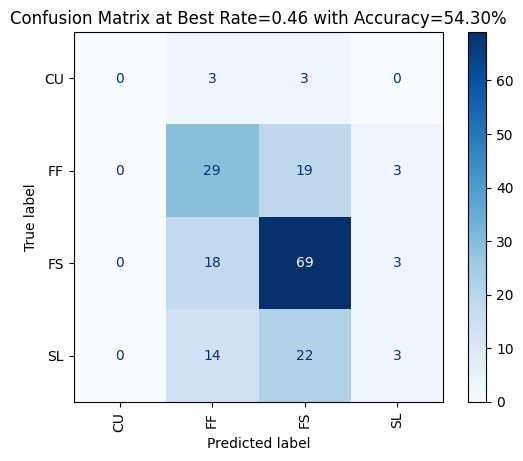

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


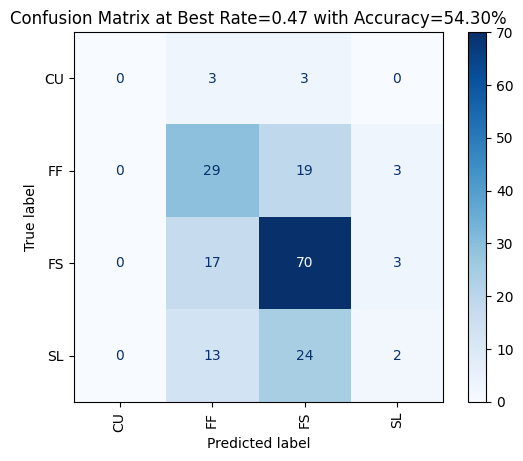

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


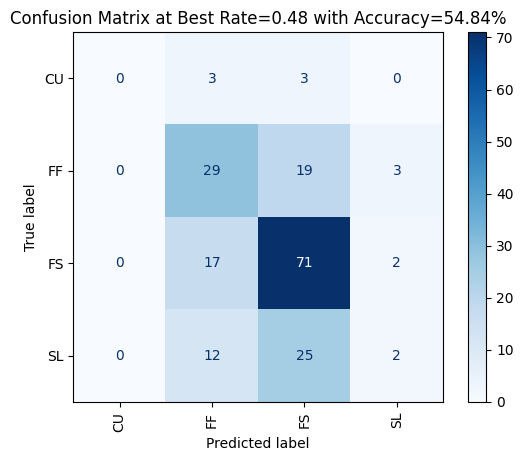

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


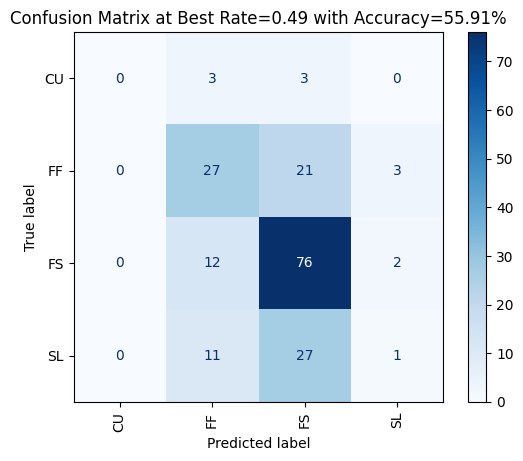

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


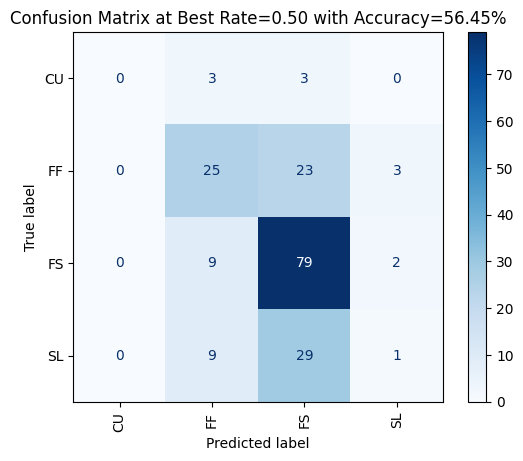

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


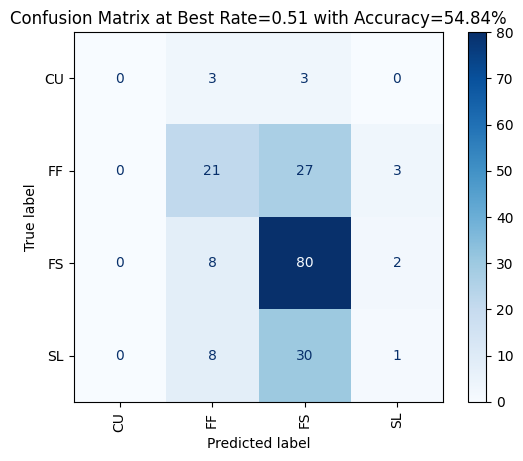

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


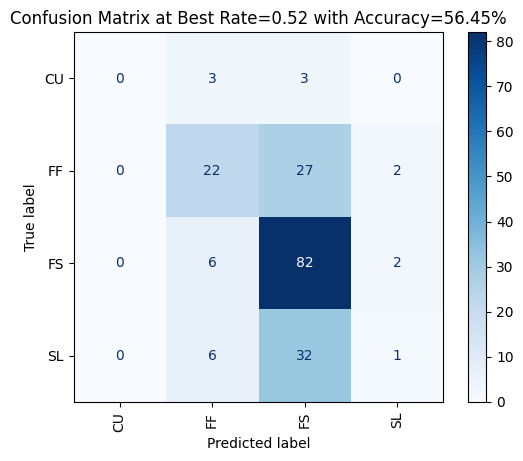

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


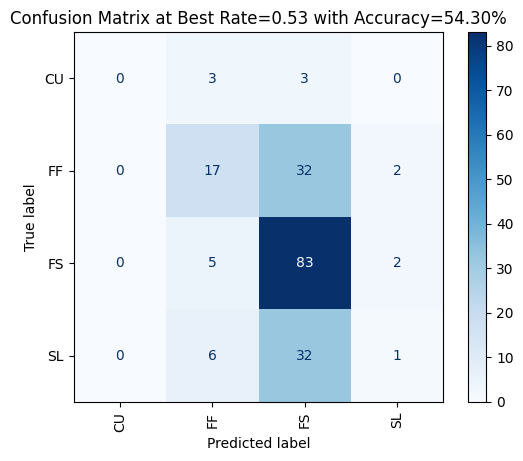

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


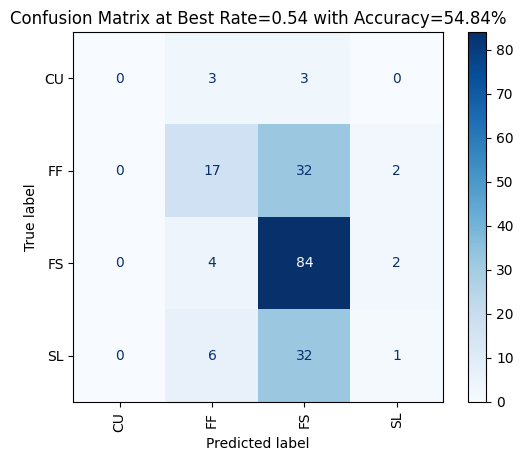

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


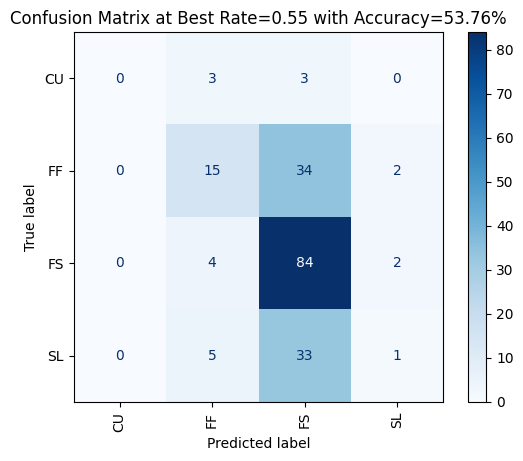

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


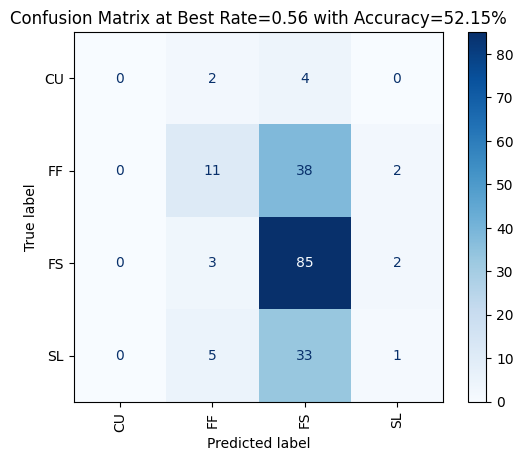

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


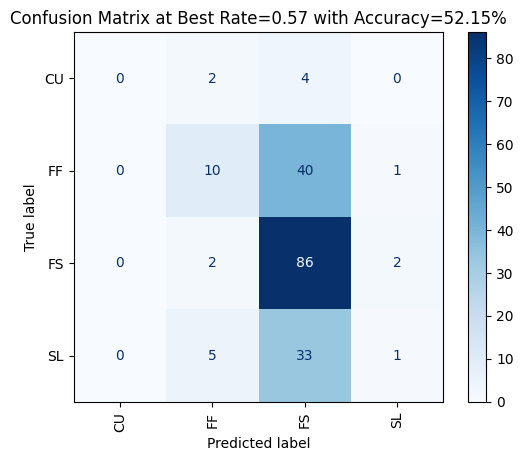

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


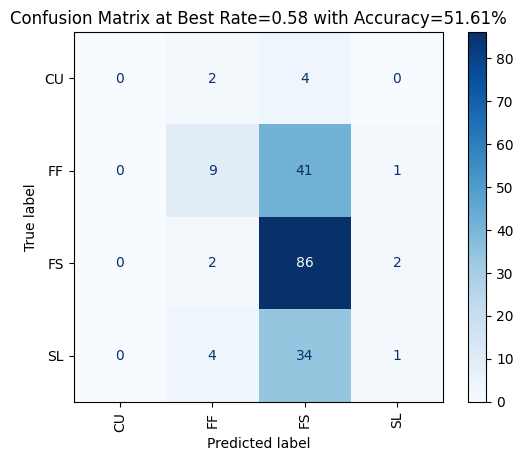

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


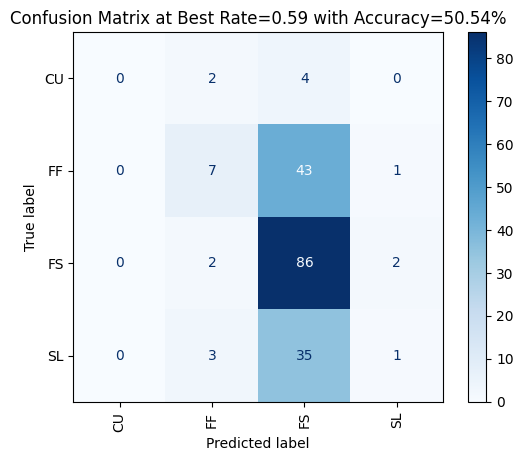

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


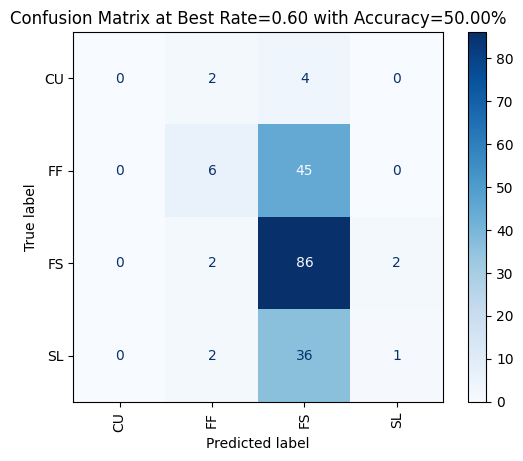

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


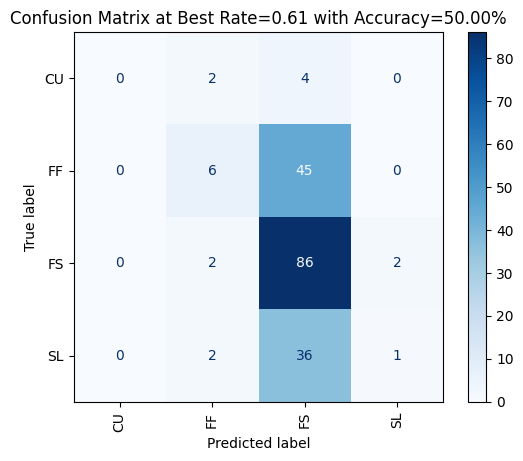

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


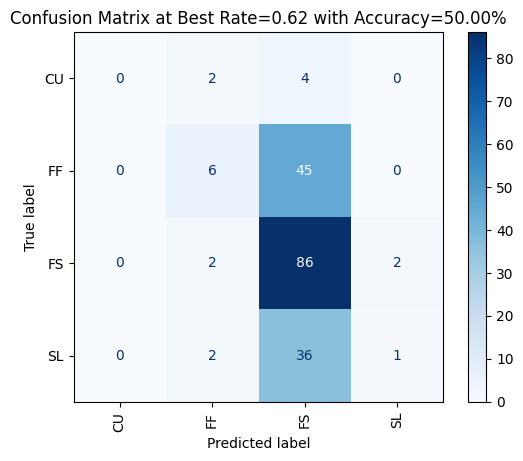

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


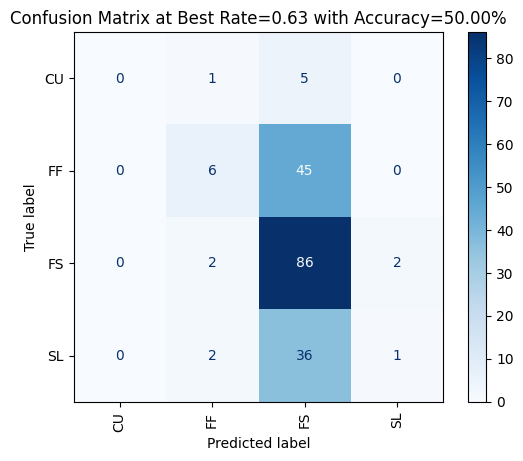

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


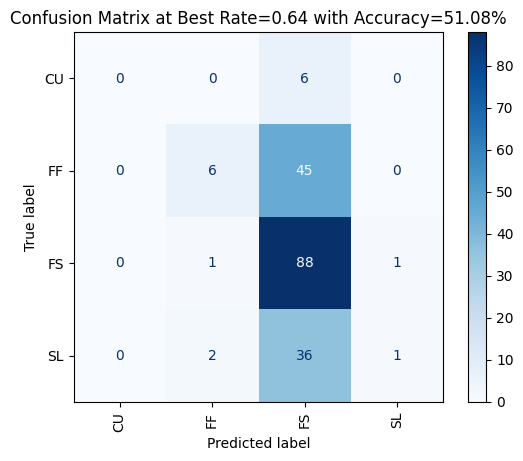

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


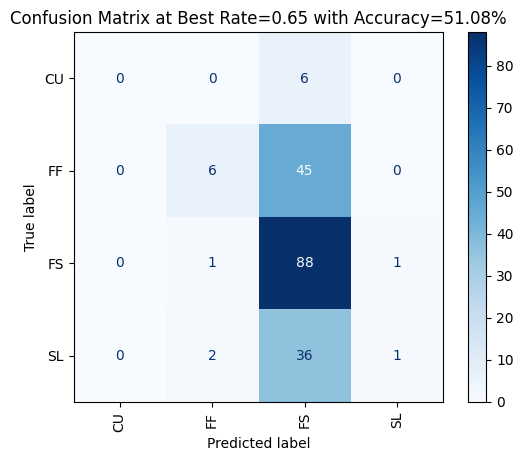

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


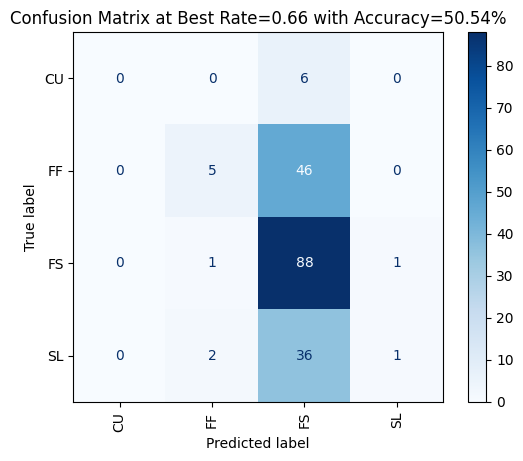

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


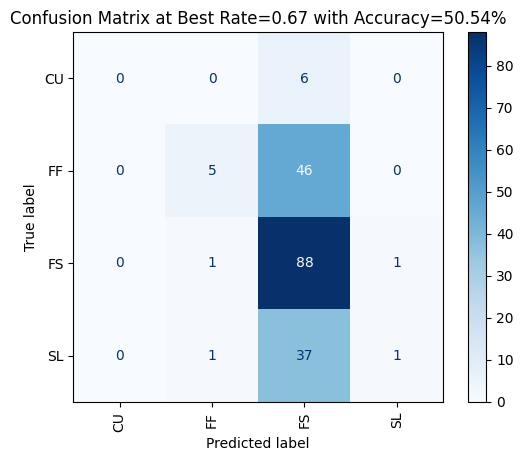

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


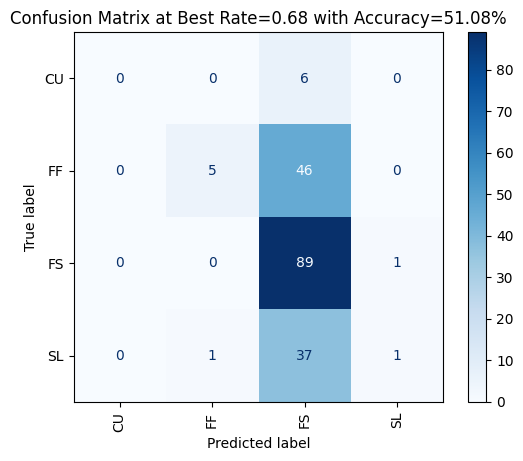

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


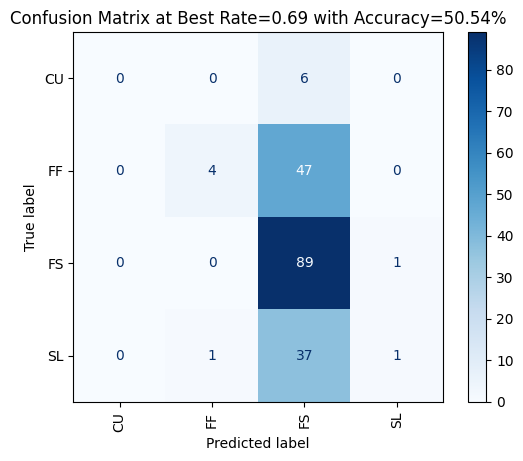

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


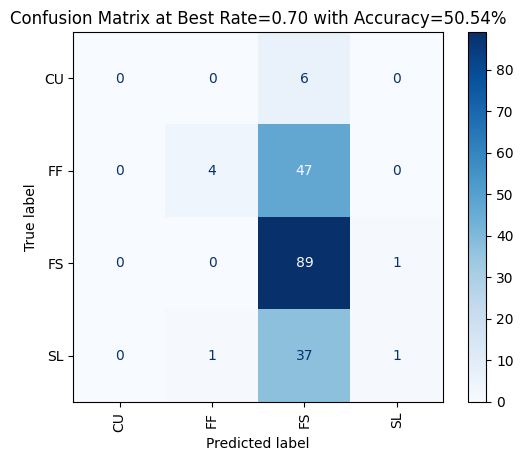

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


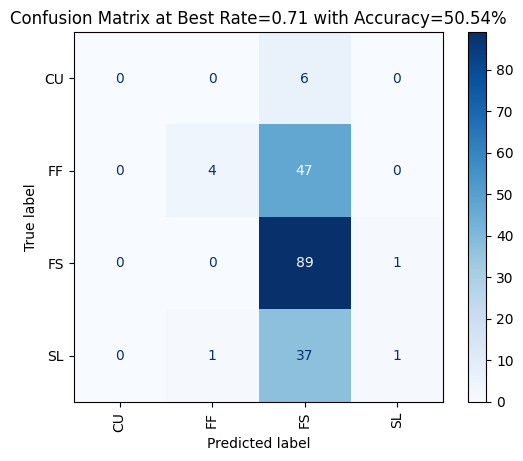

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


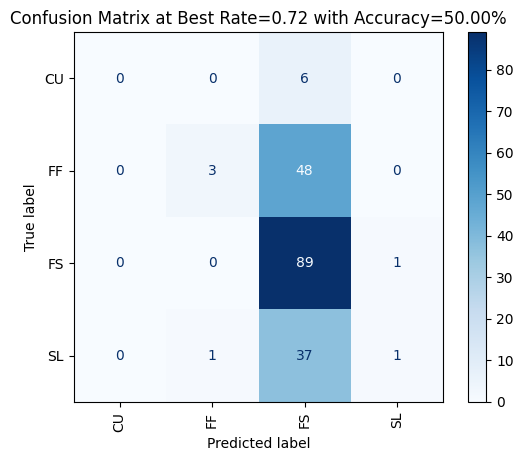

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


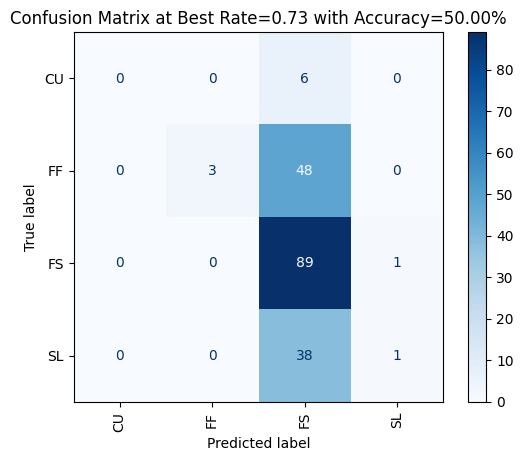

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


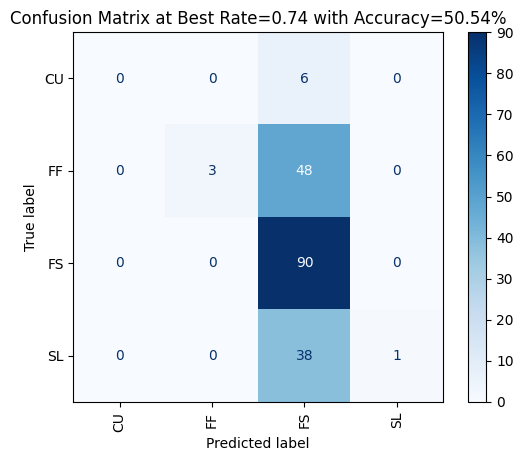

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


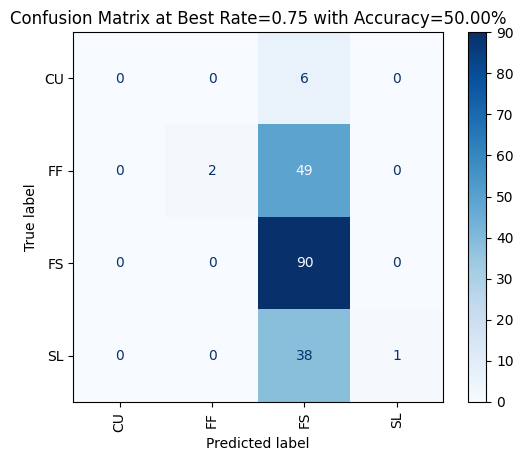

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


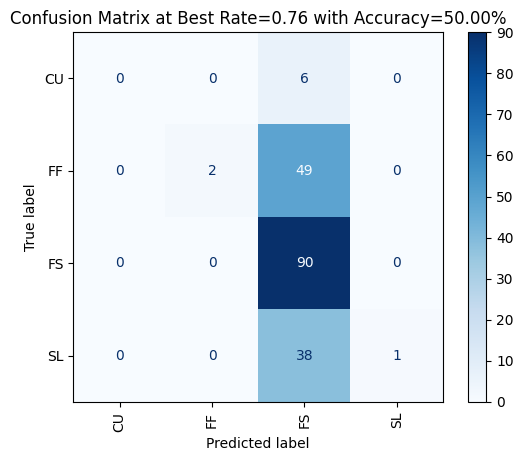

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


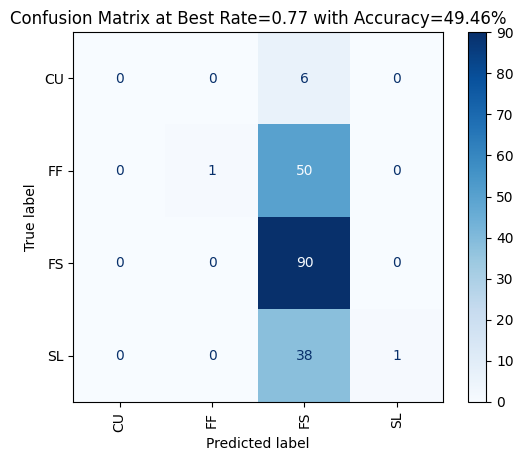

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


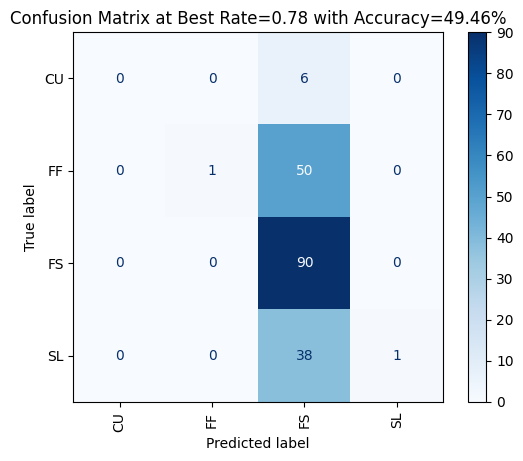

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


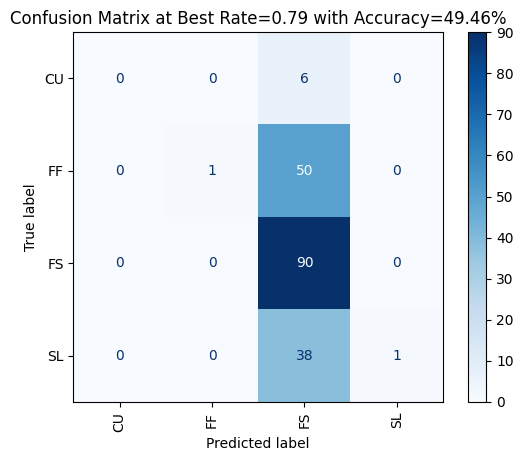

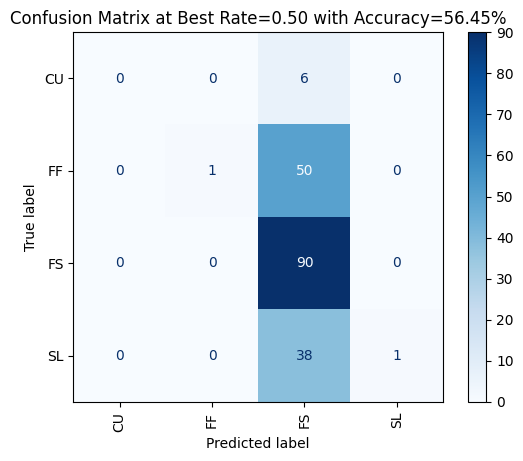

Best Rate: 0.50
Best Accuracy: 56.45%


In [93]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 假設模型和資料已經定義
# model_special, model, X_test, y_test, label_encoder, num_classes

best_rate = 0
best_accuracy = 0
best_cm = None

# 設定 rate 的範圍從 0.01 到 0.5，步長為 0.01
rates = np.arange(0.3, 0.8, 0.01)

for rate in rates:
    # 計算加權預測
    y_pred = rate * model_special.predict(X_combined_test) + (1 - rate) * model.predict(X_combined_test)

    # 計算準確率

    y_pred_classes = np.argmax(y_pred, axis=1)  # 預測的類別

    # 計算準確率
    best_cm = confusion_matrix(y_combined_test, y_pred_classes, labels=np.arange(num_classes))
    accuracy = accuracy_score(y_combined_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix at Best Rate={rate:.2f} with Accuracy={accuracy:.2%}')
    plt.show()
    # 更新最佳準確率和對應的 rate
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_rate = rate
        best_cm = confusion_matrix(y_combined_test, y_pred_classes, labels=np.arange(num_classes))

# 繪製最佳混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'Confusion Matrix at Best Rate={best_rate:.2f} with Accuracy={best_accuracy:.2%}')
plt.show()

# 輸出結果
print(f"Best Rate: {best_rate:.2f}")
print(f"Best Accuracy: {best_accuracy:.2%}")


## LSTM Model

In [ ]:
desired_order = ['FF', 'FS', 'FC', 'SI', 'CH', 'ST', 'CU', 'CS']
class_to_index = {label: index for index, label in enumerate(y_label_encoder.classes_)}
reordered_indices = [class_to_index[label] for label in desired_order]

cm = confusion_matrix(y_test, y_pred_classes, labels=reordered_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=desired_order)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix with Reordered Labels')
plt.show()# # VERSION: LSTM
# # Number of unique pitch types (target classes)
# num_classes = processed_output[output_feature].nunique()  # Assuming `y` is label-encoded

# model = Sequential([
#     # Optional: Masking layer to handle padded sequences
#     Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),

#     # First LSTM layer
#     LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),

#     # Fully connected layer
#     Dense(32, activation='relu'),

#     # Output layer
#     Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',  # Assuming `y` is label-encoded
#     metrics=['accuracy']
# )

# # Print model summary
# model.summary()

In [ ]:
# # Train the LSTM model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=20,
#     batch_size=32,
#     verbose=1
# )

## LSTM with Self-Attention

In [ ]:
class CustomAttention(Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()
        self.score_dense = tf.keras.layers.Dense(1, activation='tanh')  # Create Dense layer here

    def call(self, lstm_outputs):
        """
        lstm_outputs: (batch_size, sequence_length, hidden_dim)
        """
        # Compute attention scores (unnormalized)
        score = self.score_dense(lstm_outputs)  # Shape: (batch_size, sequence_length, 1)
        score = tf.squeeze(score, axis=-1)  # Shape: (batch_size, sequence_length)

        # Compute attention weights
        alpha = tf.nn.softmax(score, axis=1)  # Shape: (batch_size, sequence_length)

        # Compute context vector as weighted sum of LSTM outputs
        context = tf.reduce_sum(lstm_outputs * tf.expand_dims(alpha, -1), axis=1)  # Shape: (batch_size, hidden_dim)

        return context, alpha


In [ ]:
# NOTE: testing accuracy 61% on 50 epochs
# # Input shape
# sequence_length = X_train.shape[1]
# num_features = X_train.shape[2]
# num_classes = processed_output[output_feature].nunique()
# # print(sequence_length, num_features, num_classes)

# # Define the model
# inputs = Input(shape=(sequence_length, num_features))  # Input shape: (None, 12, 49)

# # Masking layer
# masked = Masking(mask_value=0.0)(inputs)  # Output: (None, 12, 49)

# # First LSTM layer
# lstm_1 = LSTM(64, return_sequences=True)(masked)  # Output: (None, 12, 64)

# # Second LSTM layer
# lstm_2 = LSTM(64, return_sequences=True)(lstm_1)  # Output: (None, 12, 64)

# # Custom Attention layer
# attention_layer = CustomAttention()
# context_vector, attention_weights = attention_layer(lstm_2)  # context_vector: (None, 64)

# # Fully connected layers
# dense_1 = Dense(32, activation='relu')(context_vector)  # Output: (None, 32)
# dense_2 = Dense(32, activation='relu')(dense_1)  # Output: (None, 32)

# # Output layer
# outputs = Dense(num_classes, activation='softmax')(dense_2)  # Output: (None, num_classes)

# # Build and compile the model
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(
#     optimizer=Adam(learning_rate=0.005),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Print the model summary
# model.summary()

In [ ]:
# Input shape
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]
num_classes = processed_output[output_feature].nunique()
# print(sequence_length, num_features, num_classes)

# Define the model
inputs = Input(shape=(sequence_length, num_features))  # Input shape: (None, 12, 49)

# Masking layer
masked = Masking(mask_value=0.0)(inputs)  # Output: (None, 12, 49)

# First LSTM layer with Dropout
lstm_1 = LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(masked)  # Output: (None, 12, 256)

# Second LSTM layer with Dropout
lstm_2 = LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(lstm_1)  # Output: (None, 12, 256)

# Custom Attention layer
attention_layer = CustomAttention()
context_vector, attention_weights = attention_layer(lstm_2)  # Context vector: (None, 256)

# Fully connected layers with Dropout
dense_1 = Dense(32, activation='relu')(context_vector)  # Output: (None, 32)
dropout_1 = Dropout(0.4)(dense_1)  # Dropout added here

dense_2 = Dense(32, activation='relu')(dropout_1)  # Output: (None, 32)
dropout_2 = Dropout(0.4)(dense_2)  # Dropout added here

# Output layer
outputs = Dense(num_classes, activation='softmax')(dropout_2)  # Output: (None, 8)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'custom_attention' (of type CustomAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 12, 44)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 12, 44)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 12, 44)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 12)             │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 12, 256)        │        308,224 │ masking[0][0],         │
│                           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 12, 256)        │        525,312 │ lstm[0][0], any[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_attention          │ [(None, 256), (None,   │            257 │ lstm_1[0][0]           │
│ (CustomAttention)         │ 12)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          8,224 │ custom_attention[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          1,056 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 843,205 (3.22 MB)

 Trainable params: 843,205 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks for better training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_combined_val, y_combined_val),
    epochs=30,               # Adjust based on model performance
    batch_size=32,           # Use a reasonable batch size for your data
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5280 - loss: 1.0584 - val_accuracy: 0.3390 - val_loss: 1.3379 - learning_rate: 0.0010
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6021 - loss: 0.9418 - val_accuracy: 0.4378 - val_loss: 1.2298 - learning_rate: 0.0010
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6016 - loss: 0.9463 - val_accuracy: 0.4378 - val_loss: 1.2738 - learning_rate: 0.0010
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6454 - loss: 0.8608 - val_accuracy: 0.4037 - val_loss: 1.2522 - learning_rate: 0.0010
Epoch 5/30
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6398 - loss: 0.8542
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6412 - loss: 0.8523 - val_accuracy: 0.3816 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6591 - loss: 0.8436 - val_accu

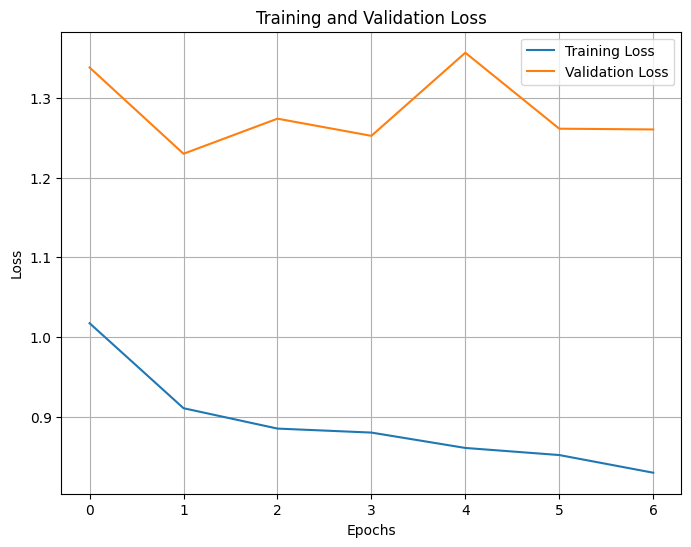

In [ ]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print(f"training Loss: {train_loss}")
print(f"training Accuracy: {train_accuracy}")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"valing Loss: {val_loss}")
print(f"valing Accuracy: {val_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 0.8648
training Loss: 0.8750032186508179
training Accuracy: 0.6299999952316284
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5318 - loss: 1.0267 
valing Loss: 1.032593846321106
valing Accuracy: 0.5387205481529236


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5602 - loss: 1.0835 
Testing Loss: 1.0835322141647339
Testing Accuracy: 0.5436241626739502


In [ ]:
# predictions = model.predict(np.expand_dims(X_train[0], axis=0))
# predicted_classes = predictions.argmax(axis=-1)  # Get class indices
# predicted_labels = label_encoder.inverse_transform(predicted_classes)  # Convert to labels
# predictions = [label_encoder.inverse_transform(model.predict(np.expand_dims(X_train[i], axis=0)).argmax(axis=-1)) for i in range(10)]
predictions = [model.predict(np.expand_dims(X_train[i], axis=0)).argmax(axis=-1) for i in range(9)]

print(predictions)
print(f"Predicted classes: {predicted_classes}")
print(f"Predicted labels: {predicted_labels}")
print(processed_output.iloc[0:8])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[array([5]), array([5]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4])]


NameError: name 'predicted_classes' is not defined

In [ ]:
label_encoder.classes_

array(['CH', 'FF', 'FS', 'SL'], dtype=object)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5602 - loss: 1.0835 
Testing Loss: 1.0835322141647339
Testing Accuracy: 0.5436241626739502
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


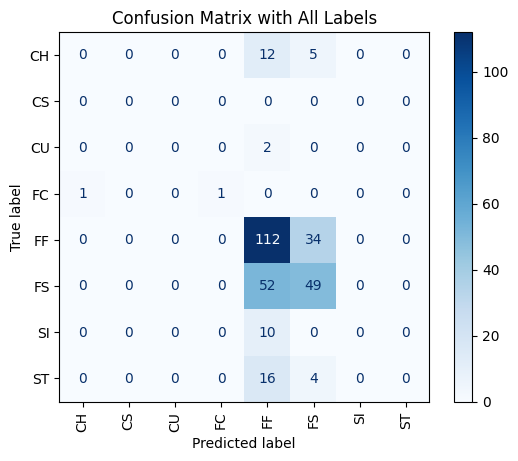

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# 使用模型進行預測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 預測的類別

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix with All Labels')
plt.show()